In [ ]:
import csv
import os
import vcf
wenjianjia_list = os.listdir('/mnt/alamo01/users/wapktz/JS-fq/Sequence_01')
for i in wenjianjia_list:
    dirs = f'/mnt/alamo01/users/wapktz/JS-fq/01pipeline/vcf_pair/{i}'
    if not os.path.exists(dirs):
        os.makedirs(dirs)

#把vcf移进来
for i in os.listdir(f'/mnt/alamo01/users/wapktz/JS-fq/Sequence_01/'):
    vdir_path = f'/mnt/alamo01/users/wapktz/JS-fq/Sequence_01/{i}/vcf'
    for v in os.listdir('/mnt/alamo01/users/wapktz/JS-fq/Sequence_01/{i}/vcf'):
        os.system(f'cp /mnt/alamo01/users/wapktz/JS-fq/Sequence_01/{i}/vcf/{v} /mnt/alamo01/users/wapktz/JS-fq/01pipeline/vcf_pair/{i}')



In [ ]:
#05 统计bayes的每个样本reads数，写成A256G的形式，过滤，只过滤测序深度,不过滤频率。
#统计每个样本的突变数量
#dp>100并且在至少2个样本中出现过的才算。
#变异类型是snp或者del或ins，这里也筛选了。
#最终输出csv文件。

import csv
import os
import vcf
wenjianjia_list = os.listdir('/mnt/alamo01/users/yangjingqi/01pipeline/vcf_pair')
for i in wenjianjia_list:
    dirs = f'/mnt/alamo01/users/yangjingqi/01pipeline/01filtered_csv_deep_sample/{i}'
    if not os.path.exists(dirs):
        os.makedirs(dirs)



for p in os.listdir('/mnt/alamo01/users/yangjingqi/01pipeline/vcf_pair'):
    prj_path = f'/mnt/alamo01/users/yangjingqi/01pipeline/vcf_pair/{p}'

    bayes_filenames=os.listdir(prj_path)
    type_list= []
    dict_mut_num = {}#在几个样本中出现过。形成列表，在列表中的才算真正的突变。
    #找出突变在几个样本中出现
    for i in bayes_filenames:
        try:
            if i.endswith('vcf'):
                i_1 = i.split('.vcf')[0]
                reads_pos_dict = {}
                path1 = prj_path+'/'+i

                vcf_reader = vcf.Reader(filename=path1)        
                for record in vcf_reader:
        #             print(record)
        #             print(record.INFO)

                    alt_count = record.INFO['AO']
                    ref_count = record.INFO['RO']
                    ref = str(record).split(',')[2].split('=')[1]
                    type0 = record.INFO['TYPE']
                    position = str(record).split(',')[1].split('=')[1]
                    dp = record.INFO['DP']
                    if type0 not in type_list:
                        type_list.append(type0)
                    for i in range(0,len(record.INFO['TYPE'])):
                        alt1 = str(record).split('=')[4].replace(')','').replace('[','').replace(']','').replace(' ','')
                        alt2 = alt1.split(",")#转成列表,碱基
                        type2 = record.INFO['TYPE'][i]
                        info = f'{ref}_{position}_{alt2[i]}'
                        alt_count1 = alt_count[i]
                        af = record.INFO['AO'][i]/(record.INFO['AO'][i] + record.INFO['RO'])
        #                 print(af)
                        if dp > 100:
        #                     reads_pos_dict[info] = {'alt':alt_count1,'ref':ref_count,'type':type2,'allele_frequency':af}
                            if info not in dict_mut_num:
                                dict_mut_num[info] = 1
                            else:
                                dict_mut_num[info] += 1
        #         print(reads_pos_dict)
        except Exception as e:
            print(f"Error: {e},{path1}")


    filtered_list = []# 测序深度>100且出现在至少2个样本中的突变。
    for k,v in dict_mut_num.items():
        if v > 1:
            filtered_list.append(k)
    # print(filtered_list)


    #根据filtered_list筛选突变，输出csv。
    for i in bayes_filenames:
        if i.endswith('vcf'):
            i_1 = i.split('.')[0]
            reads_pos_dict = {}
            path1 = prj_path +'/'+i
            try:
                vcf_reader = vcf.Reader(filename=path1)
                for record in vcf_reader:
        #             print(record)
        #             print(record.INFO)

                    alt_count = record.INFO['AO']
                    ref_count = record.INFO['RO']
                    ref = str(record).split(',')[2].split('=')[1]
                    type0 = record.INFO['TYPE']
                    position = str(record).split(',')[1].split('=')[1]
                    dp = record.INFO['DP']
                    if type0 not in type_list:
                        type_list.append(type0)
                    for i in range(0,len(record.INFO['TYPE'])):
                        alt1 = str(record).split('=')[4].replace(')','').replace('[','').replace(']','').replace(' ','')
                        alt2 = alt1.split(",")#转成列表,碱基
                        type2 = record.INFO['TYPE'][i]
                        info = f'{ref}_{position}_{alt2[i]}'
                        alt_count1 = alt_count[i]
                        af = record.INFO['AO'][i]/(record.INFO['AO'][i] + record.INFO['RO'])    
                        if dp > 100:#即使有列表了也还是需要测序深度>100的这个条件，不然有可能是出现在样本多但是测序深度不行的。
                            if info in filtered_list:
                                if type2 == 'snp' or type2 == 'del' or type2 == 'ins':#筛选变异类型
                                    reads_pos_dict[info] = {'alt':alt_count1,'ref':ref_count,'type':type2,'allele_frequency':af,'sample_exist':dict_mut_num[info]}
    #         print(reads_pos_dict)
            except Exception as e:
                print(f"Error: {e},{path1}")
            with open(f'/mnt/alamo01/users/yangjingqi/01pipeline/01filtered_csv_deep_sample/{p}/{i_1}.csv','w') as f:#表格可以加个频率
                writer = csv.writer(f)
                writer.writerow(["mutation","alt_reads","ref_reads","type","app","allele_frequency","sample_exist'"])
                for k,v in reads_pos_dict.items():
                    writer.writerow([k,v['alt'],v['ref'],v['type'],'freebayes',v['allele_frequency'],v['sample_exist']])

In [24]:
#04统计突变类型，3%-80%和80%以上的比例，先不管allele frequency，只看次数
#二代测序中3%-80%的突变，对频率有错误影响，对蛋白分布没有影响。可以加一列属于哪个样本的。加上了，次数是准的了。

#80%以下：
import os
import csv

# wenjianjia_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/yjq_sra_bioproject_rsv')
# for i in wenjianjia_list:
#     dirs = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/06product_exist/{i}'
#     if not os.path.exists(dirs):
#         os.makedirs(dirs)

# wenjianjia_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/yjq_sra_bioproject_rsv')
# for i in wenjianjia_list:
#     dirs = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/07mutation_proportion/{i}'
#     if not os.path.exists(dirs):
#         os.makedirs(dirs)

for p in os.listdir('/mnt/alamo01/users/yangjingqi/01pipeline/01filtered_csv_deep_sample'):
    prj_path = f'/mnt/alamo01/users/yangjingqi/01pipeline/01filtered_csv_deep_sample/{p}'

    dict_003_08_next_generation = {}
    for i in os.listdir(prj_path):
        if i.endswith('.csv'):
            csv_path = f'{prj_path}/{i}'
            with open(csv_path) as csvfile:
                csv_reader = csv.reader(csvfile)  
                for row in csv_reader:
                    if row[0] != 'mutation':
                        first = row[0].split('_')[0]
    #                     last = row[0].split('_')[2]
    #                     position = row[0].split('_')[1]
                        frequnecy = float(row[5])
                        mutation = row[0]
                        type1 = row[3]
                        if 0.03 <= frequnecy <= 0.8:
    #                         if len(first) == 1:#找的snv很奇怪，明明是单个突变非要写一堆，所以就不用type筛选了。
    #                             dict_003_08_next_generation[mutation] = frequnecy
                            if mutation not in dict_003_08_next_generation.keys():
                                dict_003_08_next_generation[mutation] = {}
                                dict_003_08_next_generation[mutation][i] = [frequnecy,type1]
                            else:#一定要加，不然每次都是赋值一个空字典就没办法新加进来样本。
                                dict_003_08_next_generation[mutation][i] = [frequnecy,type1]
    # print(dict_003_08_next_generation)
    # print(p)
# ----------------------------------------------------------------------------------------------------------    
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!统计所有的突变及其数量，频率。 后面看在哪个突变上要用。             
    with open(f'/mnt/alamo01/users/yangjingqi/01pipeline/06product_exist/06isnv_mutation_{p}.csv','w') as f:
        writer = csv.writer(f)
        writer.writerow(['isnv','sample','frequency','type'])
        for k,v in dict_003_08_next_generation.items():
            for s,info in v.items():
                frequency = info[0]
                type3 = info[1]
                writer.writerow([k,s.split('.')[0],frequency,type3])
            
#-----------------------------------------------------------------------------------------------------------
    
#统计数量
    dict_num_mutation = {'A_G':0,'A_T':0,'A_C':0,'G_A':0,'G_C':0,'G_T':0,'T_C':0,'T_A':0,'T_G':0,'C_A':0,'C_T':0,'C_G':0,'del':0,'ins':0}
    for k,v in dict_003_08_next_generation.items():
        ref = k.split('_')[0]
        alt = k.split('_')[2]
        for s in v.values():
            type2 = s[1]
    #         print(type2)
        if type2 =='snp':
            name = f'{ref}_{alt}'
            add_count = len(v)
        #     print(name)
            for m,c in dict_num_mutation.items():
                if name == m:
                    dict_num_mutation[m] += add_count  #!!!赋值不可以只写c，一定要写成键的值。
        if type2 =='del':
            add_count = len(v)

            dict_num_mutation['del'] += add_count
        if type2 =='ins':
            add_count = len(v)

            dict_num_mutation['ins'] += add_count



    print(dict_num_mutation)
    count_all = 0
    for k,v in dict_num_mutation.items():
        count_all += v
    print(count_all)
    
    dict_proportion =  dict.fromkeys(dict_num_mutation.keys())
    for k in dict_proportion.keys():
        dict_proportion[k] = {}
        dict_proportion[k]['count'] = dict_num_mutation[k]
        if count_all!= 0:
            dict_proportion[k]['proportion'] = dict_proportion[k]['count']/count_all
        else:
            dict_proportion[k]['proportion'] = '/'
    print(dict_proportion)  
    with open(f"/mnt/alamo01/users/yangjingqi/01pipeline/07mutation_proportion/07isnv_mutation_type_{p}.csv","w") as csvfile: 
        writer = csv.writer(csvfile)
        writer.writerow(['mutation_type','count','proportion','group'])
        for k,v in dict_proportion.items():
            writer.writerow([k,v['count'],v['proportion'],'iSNV'])

        
        
        
        
        
# #-----------------------------------------------------------------------
# #80%上：

    dict_003_08_next_generation = {}
    for i in os.listdir(prj_path):
        if i.endswith('.csv'):
            csv_path = f'{prj_path}/{i}'
            with open(csv_path) as csvfile:
                csv_reader = csv.reader(csvfile)  
                for row in csv_reader:
                    if row[0] != 'mutation':
                        first = row[0].split('_')[0]
    #                     last = row[0].split('_')[2]
    #                     position = row[0].split('_')[1]
                        frequnecy = float(row[5])
                        mutation = row[0]
                        type1 = row[3]
                        if  frequnecy > 0.8:
    #                         if len(first) == 1:#找的snv很奇怪，明明是单个突变非要写一堆，所以就不用type筛选了。
    #                             dict_003_08_next_generation[mutation] = frequnecy
                            if mutation not in dict_003_08_next_generation.keys():
                                dict_003_08_next_generation[mutation] = {}
                                dict_003_08_next_generation[mutation][i] = [frequnecy,type1]
                            else:#一定要加，不然每次都是赋值一个空字典就没办法新加进来样本。
                                dict_003_08_next_generation[mutation][i] = [frequnecy,type1]

    #统计数量
    dict_num_mutation = {'A_G':0,'A_T':0,'A_C':0,'G_A':0,'G_C':0,'G_T':0,'T_C':0,'T_A':0,'T_G':0,'C_A':0,'C_T':0,'C_G':0,'del':0,'ins':0}
    for k,v in dict_003_08_next_generation.items():
        ref = k.split('_')[0]
        alt = k.split('_')[2]
        for s in v.values():
            type2 = s[1]
    #         print(type2)
        if type2 =='snp':
            name = f'{ref}_{alt}'
            add_count = len(v)
        #     print(name)
            for m,c in dict_num_mutation.items():
                if name == m:
                    dict_num_mutation[m] += add_count  #!!!赋值不可以只写c，一定要写成键的值。
        if type2 =='del':
            add_count = len(v)

            dict_num_mutation['del'] += add_count
        if type2 =='ins':
            add_count = len(v)

            dict_num_mutation['ins'] += add_count



    # print(dict_num_mutation)

    #算比例的分母
    count_all = 0
    for k,v in dict_num_mutation.items():
        count_all += v
    # print(count_all)
    dict_proportion =  dict.fromkeys(dict_num_mutation.keys())
    for k in dict_proportion.keys():
        dict_proportion[k] = {}
        dict_proportion[k]['count'] = dict_num_mutation[k]
        if count_all!= 0:
            dict_proportion[k]['proportion'] = dict_proportion[k]['count']/count_all
        else:
            dict_proportion[k]['proportion'] = '/'
    # print(dict_proportion)  
    with open(f"/mnt/alamo01/users/yangjingqi/01pipeline/07mutation_proportion/07snp_mutation_type_{p}.csv","w") as csvfile: 
        writer = csv.writer(csvfile)
        writer.writerow(['mutation_type','count','proportion','group'])
        for k,v in dict_proportion.items():
            writer.writerow([k,v['count'],v['proportion'],'SNP'])

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!统计所有的突变及其数量，频率。 后面看在哪个突变上要用。             
    with open(f'/mnt/alamo01/users/yangjingqi/01pipeline/06product_exist/06snp_mutation_{p}.csv','w') as f:
        writer = csv.writer(f)
        writer.writerow(['isnv','sample','frequency','type'])
        for k,v in dict_003_08_next_generation.items():
            for s,info in v.items():
                frequency = info[0]
                type3 = info[1]
                writer.writerow([k,s.split('.')[0],frequency,type3])
            
            
            

{'A_G': 114, 'A_T': 34, 'A_C': 19, 'G_A': 120, 'G_C': 15, 'G_T': 434, 'T_C': 132, 'T_A': 136, 'T_G': 535, 'C_A': 179, 'C_T': 309, 'C_G': 23, 'del': 19, 'ins': 9}
2078
{'A_G': {'count': 114, 'proportion': 0.0548604427333975}, 'A_T': {'count': 34, 'proportion': 0.016361886429258902}, 'A_C': {'count': 19, 'proportion': 0.009143407122232916}, 'G_A': {'count': 120, 'proportion': 0.05774783445620789}, 'G_C': {'count': 15, 'proportion': 0.007218479307025986}, 'G_T': {'count': 434, 'proportion': 0.2088546679499519}, 'T_C': {'count': 132, 'proportion': 0.06352261790182868}, 'T_A': {'count': 136, 'proportion': 0.06544754571703561}, 'T_G': {'count': 535, 'proportion': 0.25745909528392685}, 'C_A': {'count': 179, 'proportion': 0.08614051973051011}, 'C_T': {'count': 309, 'proportion': 0.14870067372473533}, 'C_G': {'count': 23, 'proportion': 0.011068334937439845}, 'del': {'count': 19, 'proportion': 0.009143407122232916}, 'ins': {'count': 9, 'proportion': 0.004331087584215592}}
{'A_G': 443, 'A_T': 497

KeyboardInterrupt: 

In [ ]:
# 05 翻译蛋白质，要加3-80%的。isnv的
#分批次
#非同义氨基酸突变的具体情况和不同蛋白非同义突变的数量。
#插入加了。
from Bio.Seq import Seq
import os
import pandas as pd


wenjianjia_list = os.listdir('/mnt/alamo01/users/yangjingqi/01pipeline/vcf_pair')
for i in wenjianjia_list:
    dirs = f'/mnt/alamo01/users/yangjingqi/01pipeline/08product_frequency/{i}'
    if not os.path.exists(dirs):
        os.makedirs(dirs)
dict_pep_cds = {'266_21555':'ORF1ab','21563_25384':"S",'25393_26220':"ORF3a",'26245_26472':"E",'26523_27191':"M",'27202_27387':"ORF6",'27394_27759':"ORF7a",'27756_27887':"ORF7b",'27894_28259':"ORF8",'28274_29533':"N",'29558_29674':"ORF10"}

csv_list = os.listdir('/mnt/alamo01/users/yangjingqi/01pipeline/06product_exist')
for c in csv_list:
    if c.endswith('csv'):
        c1 = c.split('_')[2].split('.')[0]
        csv_path = f'/mnt/alamo01/users/yangjingqi/01pipeline/06product_exist/06isnv_mutation_{c1}.csv'
        with open(csv_path) as csvfile:
            dict_info = {}
            info_list = []
            csv_reader = csv.reader(csvfile)  
            for row in csv_reader:
                if row[0] != 'isnv':
                    mut = row[0]
                    if mut not in info_list:
                        info_list.append(mut)
        dict_info = dict.fromkeys(info_list)


        for i in dict_info.keys():#嵌套字典可以这样赋值：1、dict_info = dict.fromkeys(info_list)2、每个键都赋值成空字典，再正常加就好了
            dict_info[i] = {}


    #----------------
    #新加的，统计每个突变的样本数量。
        df = pd.read_csv(csv_path)
        df_counts = df.isnv.value_counts()
        #print(df_counts)
        outputpath=f'/mnt/alamo01/users/yangjingqi/01pipeline/06product_exist/mut_sample_number/{c1}_mut_sample_number.csv'
        df_counts.to_csv(outputpath,sep=',',index=True,header=False)

        dict_mut_num = {}
        
        mut_number_path = f'/mnt/alamo01/users/yangjingqi/01pipeline/06product_exist/mut_sample_number/{c1}_mut_sample_number.csv'
        with open(mut_number_path) as csvfile:
            csv_reader = csv.reader(csvfile) 
            for row in csv_reader:
                isnv = row[0]
                num = row[1]
                dict_mut_num[isnv] = num
        # print(dict_mut_num)


    #--------------
        with open(csv_path) as csvfile:
            csv_reader = csv.reader(csvfile)  
            for row in csv_reader:
                if row[0] != 'isnv':
                    mut = row[0]
                    pos = int(row[0].split('_')[1])
                    fre = float(row[2])
                    type4 = row[3]
                    first = row[0].split('_')[0]
                    last = row[0].split('_')[2]
                    #分一下位置，del和ins的有可能结束位置和开始位置不在同一段蛋白里面。不太可能
                    if type4 == 'del':#按照突变前的长度算
                        pos_end = pos + len(first) -1
                    if type4 == 'ins':#按照突变后的长度算
                        pos_end = pos + len(last) -1          
                    for k,v in dict_pep_cds.items():
                        start = int(k.split('_')[0])
                        end = int(k.split('_')[1])
                        if type4 == 'snp':
                            if start <= pos <= end: #这里一定要转化成int，不然就是字符串是不对的。    
                                dict_info[mut]['product'] = v
                                dict_info[mut]['type'] = type4
                                dict_info[mut]['start'] = start
                                dict_info[mut]['end'] = end
                                dict_info[mut]['sample_number'] = dict_mut_num[mut]
        #                         dict_info[mut]['frequency'] = fre 频率先不考虑了，有好多样本的
                        if type4 == 'del' or type4 == 'ins':
                            if start <= pos <= end and start <= pos_end <= end: #这里一定要转化成int，不然就是字符串是不对的。    
                                dict_info[mut]['product'] = v
                                dict_info[mut]['type'] = type4
                                dict_info[mut]['start'] = start
                                dict_info[mut]['end'] = end
        #                         dict_info[mut]['frequency'] = fre
                                dict_info[mut]['sample_number'] = dict_mut_num[mut]




        # print(dict_info)
        ##---------------------------------------------------------------------------------------
        #去除不在cds范围内的碱基突变                   
        dict_info_feikong = {}            
        for i in dict_info.keys():
            if dict_info[i]:
                dict_info_feikong[i] = dict_info[i]
        # print(dict_info_feikong)

        #获取突变前后的三个碱基，蛋白位置不知道，可以用什么蛋白
        dict_aa_mut = {}#非同义突变的字典
        dict_aa_synonymous_mut = {}
        ref_seq = 'ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGACACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTCTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTCAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACAAAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCAGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTATTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGTCTGGTTTTAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTACTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGACACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACCTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGAGTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAAAGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTGAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTAATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGATGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAACATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTACTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCAGTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCATCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGGAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCCAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCAGTAGGGGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTATCCCCATGTGATTTTAATAGCTTCTTAGGAGAATGACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'
        #ref_seq = 'ACGCGAAAAAATGCGTACAACAAACTTGCGTAAACCAAAAAAATGGGGCAAATAAGAATTTGATAAGTACCACTTAAATTTAACTCCCTTGGTTAGAGATGGGCAGCAATTCATTGAGTATGATAAAAGTTAGATTACAAAATTTGTTTGACAATGATGAAGTAGCATTGTTAAAAATAACATGCTATACTGACAAATTAATACATTTAACTAATGCATTGGCTAAGGCAGTGATACATACAATCAAATTGAATGGCATTGTATTTGTGCATGTTATTACAAGTAGTGATATTTGCCCTAATAATAATATTGTAGTGAAATCCAATTTCACAACAATGCCAGTGTTACAAAATGGAGGTTATATATGGGAAATGATGGAATTAACACACTGCTCTCAACCTAATGGCCTAATAGATGACAATTGTGAAATTAAATTCTCCAAAAAACTAAGTGATTCAACAATGACCAATTATATGAATCAATTATCTGAATTACTTGGATTTGATCTTAATCCATAAATTATAATAAATATCAACTAGCAAATCAATGTCACTAACACCATTAGTTAATATAAAACTTGACAGAAGATAAAAATGGGGCAAATAAATCAATTCAGCCGACCCAACCATGGACACAACACACAATGACACCACACCACAAAGACTGATGATCACAGACATGAGACCATTGTCACTTGAGACTATAATAATATCACTAACCAGAGACATCATAACACACAGATTTATATACTTGATAAATCATGAATGTATAGTGAGAAAACTTGATGAAAGACAGGCCACATTTACATTCCTGGTCAACTATGAAATGAAACTATTGCACAAAGTGGGAAGCACTAAATACAAAAAATATACTGAATACAACACAAAATATGGCACTTTTCCTATGCCAATATTTATCAATCATGATGGGTTCTTAGAATGCATTGGCATTAAGCCTACAAAGCACACTCCCATAATATACAAGTATGATCTCAATCCATGAATTTCAACACAAGAGTCACACAATCTGAAATAACAACTTCATGCATAACCACACTCCATAGTTCAAATGGAGCCTGAAAATTATAGTAATTTAAAATTAAGGAGAGACATAAGATGAAAGATGGGGCAAATACAAAAATGGCTCTTAGCAAAGTCAAGTTGAATGATACACTCAACAAAGATCAACTTCTGTCATCCAGCAAATACACCATCCAACGGAGCACAGGAGATAGTATTGATACTCCTAATTATGATGTGCAGAAACACATCAATAAGTTATGTGGCATGTTATTAATCACAGAAGATGCTAATCATAAATTCACTGGGTTAATAGGTATGTTATATGCTATGTCTAGATTAGGAAGAGAAGACACCATAAAAATACTCAGAGATGCGGGATATCATGTAAAAGCAAATGGAGTGGATGTAACAACACATCGTCAAGATATTAATGGGAAAGAAATGAAATTTGAAGTGTTAACATTGTCAAGCTTAACAACTGAAATTCAAATCAACATTGAGATAGAATCTAGAAAATCCTACAAAAAAATGCTAAAAGAAATGGGAGAGGTAGCTCCAGAATACAGGCATGACTCTCCTGATTGTGGGATGATAATATTATGTATAGCGGCATTAGTAATAACCAAATTAGCAGCAGGGGATAGATCTGGTCTTACAGCTGTGATTAGGAGGGCTAATAATGTCCTAAAAAATGAAATGAAACGTTATAAAGGCTTACTACCCAAGGATATAGCCAACAGCTTCTATGAAGTGTTTGAAAAATATCCTCACTTTATAGATGTTTTTGTTCATTTTGGTATAGCACAATCTTCTACCAGAGGTGGCAGTAGAGTTGAAGGGATTTTTGCTGGATTGTTTATGAATGCCTATGGTGCAGGGCAAGTGATGTTACGGTGGGGGGTCTTAGCAAAATCAGTTAAAAATATTATGCTAGGACACGCTAGTGTGCAAGCAGAAATGGAACAAGTTGTGGAGGTTTATGAATATGCCCAAAAATTGGGTGGAGAAGCAGGGTTCTACCATATATTGAACAACCCAAAAGCATCATTATTGTCTTTGACTCAATTTCCTCACTTCTCCAGTGTAGTATTAGGCAATGCTGCTGGCCTAGGCATAATGGGAGAATACAGAGGTACACCAAGGAATCAAGATCTATATGATGCTGCAAAAGCATATGCTGAACAACTCAAAGAAAATGGTGTGATTAACTACAGTGTATTAGACTTGACAGCAGAAGAACTAGAGGCTATCAAACATCAGCTTAATCCAAAAGATAATGATGTAGAGCTTTGAGTTAATAAAAAAAATGGGGCAAATAAAACATCATGGAAAAGTTTGCTCCTGAATTCCATGGAGAAGATGCAAACAACAGAGCTACCAAATTCCTAGAATCAATAAAGGGCAAATTCACATCACCTAAAGATCCCAAGAAAAAAGATAGTATCATATCTGTCAACTCAATAGATATAGAAGTAACCAAAGAAAGCCCTATAACATCAAATTCAACCATTATAAACCCAACAAATGAGACAGATGATACTGTAGGGAACAAGCCCAATTATCAAAGAAAACCTCTAGTAAGTTTCAAAGAAGACCCTACGCCAAGTGATAATCCCTTTTCAAAACTATACAAAGAAACCATAGAAACATTTGATAACAATGAAGAAGAATCTAGCTATTCATATGAAGAAATAAATGATCAGACAAACGATAATATAACAGCAAGATTAGATAGGATTGATGAAAAATTAAGTGAAATACTAGGAATGCTTCACACATTAGTAGTAGCGAGTGCAGGACCTACATCTGCTCGGGATGGTATAAGAGATGCCATGGTTGGTTTAAGAGAAGACATGATAGAAAAAATCAGAACTGAAGCATTAATGACCAATGACAGACTAGAAGCTATGGCAAGACTCAGGAATGAGGAAAGTGAAAAGATGGCAAAAGACACATCAGATGAAGTGTCTCTCAATCCAACATCAGAGAAATTGAACAACCTGTTGGAAGGGAATGATAGTGACAATGATCTATCACTTGATGATTTCTGATCAGTTACCAATCTGTACATCAACACACAACACCAACAGAAGACCAACAAACAAACCAACTCACCCATCCAACCAAACATCTATACGCCAATCAGCCAATCCAAAACTAGCCACCCGGAAAAAATAGATACTATAGTTACAAAAAAAGATGGGGCAAATATGGAAACATACGTGAACAAACTTCACGAAGGCTCCACATACACAGCTGCTGTTCAATACAATGTCTTAGAAAAAGACGATGACCCTGCATCACTTACAATATGGGTGCCCATGTTCCAATCATCCATGCCAGCAGATTTACTTATAAAAGAACTAGCTAATGTCAACATACTAGTGAAACAAATATCCACACCCAATGGACCTTCATTAAGAGTCATGATAAACTCAAGAAGTGCAGTGCTAGCACAAATGCCCAGCAAATTTACCATATGTGCCAATGTGTCCTTGGATGAAAGAAGCAAGCTGGCATATGATGTAACCACACCCTGTGAAATCAAGGCATGTAGTCTAACATGCCTAAAATCAAAAAATATGTTAACTACAGTTAAAGATCTCACTATGAAAACACTCAACCCAACACATGACATCATTGCTTTATGTGAATTTGAAAATATAGTAACATCAAAAAAAGTCATAATACCAACATACCTAAGATCCATCAGTGTCAGAAATAAAGATCTGAACACACTTGAAAATATAACAACCACTGAATTCAAAAATGCCATCACAAATGCAAAAATCATCCCTTACTCAGGATTACTGTTAGTCATCACAGTGACTGACAACAAAGGAGCATTCAAATACATAAAGCCACAAAGTCAATTTATAGTAGATCTTGGAGCTTACCTAGAAAAAGAAAGTATATATTATGTTACAACAAATTGGAAGCACACAGCTACACGATTTGCAATCAAACCCATGGAAGATTAACCTTTTTCTTCTACATCAGTGAGTTGATTCATACAAACTTTCTACCTACATTCTTCACTTCACCATCATAATCACCAACCCTCTGTGGTTCAACTAATCAAACAAAACCCATCTGGAGCCTCAGATCATCCCAAGTCATTGTTCATCAGATCTAGTACTCAAATAAGTTAATAAAAATATCCACATGGGGCAAATAATCATTGGAGGAAATCCAACTAATCACAATATCTGTCAACATAGACAAGTCAACACGCCAGGCAAAATCAACCAATGGAAAATACATCCATAACAATAGAATTCTCAAGCAAATTCTGGCCTTACTTTACACTAATACACATGATAACAACAATAATCTCTTTGCTAATCATAATCTCCATCATGATTGCAATACTGAACAAACTCTGTGAATATAACGTATTCCATAACAAAACCTTTGAGCTACCAAGAGCTCGAGTCAATACATAGCATTCACCAATCTGATGGCACAAAACAGTAACCTTGCATTTGTAAGTGAACAACCCTCACCTCTTTACAAAACCACATCAACATCTCACCATGCAAGCCATCATCCATATTATAAAGTAGTTAATTAAAAATAATCATAACAATGAACTAAGATATTAAGACTAACAATAACGTTGGGGCAAATGCAAACATGTCCAAAAACAAGGACCAACGCACCACCAAGACACTAGAAAAGACCTGGGACACTCTCAATCATCTATTATTCATATCATCGTGCTTATACAAGTTAAATCTTAAATCTATAGCACAAATCACATTATCCATTCTGGCAATGATAATCTCAACTTCACTTATAATTGCAGCCATCATATTCATAGCCTCGGCAAACCACAAAGTCACACTAACAACTGCAATCATACAAGATGCAACAAGCCAGATCAAGAACACAACCCCAACATACCTCACCCAGAATCCCCAGCTTGGAATCAGCTTCTCCAATCTGTCTGAAACTACATCACAAACCACCACCATACTAGCTTCAACAACACCAAGTGTCAAGTCAACCCTGCAATCCACAACAGTCAAGACCAAAAACACAACAACAACCAAAATACAACCCAGCAAGCCCACCACAAAACAACGCCAAAACAAACCACCAAACAAACCCAATAATGATTTTCACTTTGAAGTGTTCAACTTTGTACCTTGCAGCATATGCAGCAACAATCCAACCTGCTGGGCTATCTGTAAAAGAATACCAAACAAAAAACCTGGAAAGAAAACCACCACCAAGCCCACAAAAAAACCAACCATCAAGACAACCAAAAAAGATCTCAAACCTCAAACCACAAAACCAAAGGAAGTACCTACCACCAAGCCCACAGAAAAGCCAACCATCAACACCACCAAAACAAACATCAGAACTACACTGCTCACCAACAATACCACAGGAAATCCAGAACACACAAGTCAAAAGGGAACCCTCCACTCAACCTCCTCCGATGGCAATCCAAGCCCTTCACAAGTCTATACAACATCCGAGTACCTATCACAACCTCCATCTCCATCCAACACAACAAACCAGTAGTCATTAAAAAGCGTATTATTGCAAAAAGCCATGACCAAATCAACCAGAATCAAAATCAACTCTGGGGCAAATAACAATGGAGTTGCCAATCCTCAAAACAAATGCAATTACCGCAATCCTTGCTGCAGTCACACTCTGTTTTGCTTCCAGTCAAAACATCACTGAAGAATTTTATCAAACAACATGCAGTGCAGTCAGCAAAGGCTATCTTAGTGCTCTAAGAACTGGTTGGTATACTAGTGTTATAACTATAGAATTAAGTAATATCAAGGAAAATAAGTGTAATGGAACAGACGCTAAGGTAAAATTGATAAAACAAGAATTAGATAAATATAAAAGTGCTGTAACAGAATTGCAGTTGCTCATGCAAAGCACACCGGCAACCAACAATCGAGCCAGAAGAGAACTACCAAGGTTTATGAATTATACACTCAACAATACCAAAAATACCAATGTAACATTAAGCAAGAAAAGGAAAAGAAGATTTCTTGGCTTTTTGTTAGGTGTTGGATCTGCAATCGCCAGTGGCATTGCTGTATCTAAGGTCCTGCACCTAGAAGGGGAAGTGAACAAAATCAAAAGTGCTCTACTATCCACAAACAAGGCTGTAGTCAGCTTATCAAATGGAGTTAGTGTCTTAACCAGCAAAGTGTTAGACCTCAAAAACTATATAGATAAACAGTTGTTACCTATTGTGAACAAGCAAAGCTGTAGCATATCAAACATTGAAACTGTGATAGAGTTCCAACAAAAGAACAACAGACTACTAGAGATTACCAGGGAATTTAGTGTTAATGCAGGTGTAACTACACCTGTAAGCACTTATATGTTAACAAATAGTGAATTATTATCATTAATCAATGATATGCCTATAACAAATGATCAGAAAAAGTTAATGTCCAACAATGTTCAAATAGTTAGACAGCAAAGTTACTCTATCATGTCCATAATAAAGGAGGAAGTCTTAGCATATGTAGTACAATTACCACTATATGGTGTAATAGATACACCTTGTTGGAAACTGCACACATCCCCTCTATGTACAACCAACACAAAGGAAGGGTCCAACATCTGTTTAACAAGAACCGACAGAGGATGGTACTGTGACAATGCAGGATCAGTATCTTTCTTCCCACTAGCTGAAACATGTAAAGTTCAATCGAATCGAGTATTTTGTGACACAATGAACAGTTTAACATTACCAAGTGAAGTAAATCTCTGCAACATTGACATATTCAACCCCAAATATGATTGCAAAATTATGACTTCAAAAACAGATGTAAGCAGCTCCGTTATCACATCTCTAGGAGCCATTGTGTCATGCTATGGCAAAACTAAATGTACAGCATCCAATAAAAATCGTGGAATCATAAAGACATTTTCTAACGGGTGCGATTATGTATCAAATAAGGGGGTTGACACTGTGTCTGTAGGTAATACATTATATTATGTAAATAAGCAAGAAGGCAAAAGTCTCTATGTAAAAGGTGAACCAATAATAAATTTCTATGACCCATTAGTGTTCCCCTCTGATGAATTTGATGCATCAATATCTCAAGTCAATGAGAAGATTAACCAGAGCCTAGCATTTATTCGTAAATCCGATGAATTATTACATAATGTAAATGCTGGTAAATCCACCATAAATATCATGATAACTACTATAATTATAGTGATTATAGTAATATTGTTATCATTAATTGCCGTTGGACTGCTCCTATACTGCAAGGCCAGAAGCACACCAGTCACACTAAGCAAGGATCAACTGAGTGGTATAAATAATATTGCATTTAGTAACTAAATAAAAATAGCACCTAATCATGTTCTTACAATGGTTTCATATCTGCTCATAGACAACCCATCTATCATTGGATTTTCTTAAAATCTGAACTTCATCGAAACTCTCATCTATAAACCATCTCACTTACATTATTTAAGTAGATTCCTAGTTTATAGTTATATAAAACAATTGAATACCAGATTAACTTACTATTTGTAAAAAATGAGAACTGGGGCAAATATGTCACGAAGGAATCCTTGCAAATTTGAAATTCGAGGTCATTGCTTGAATGGTAAGAGGTGTCATTTTAGTCATAATTATTTTGAATGGCCACCCCATGCACTGCTTGTAAGACAAAACTTTATGTTAAACAGAATACTTAAGTCTATGGATAAAAGCATCGATACTTTATCAGAAATAAGTGGAGCTGCAGAGTTGGACAGAACAGAAGAGTATGCCCTCGGTGTAGTTGGAGTGCTAGAGAGTTATATAGGATCTATAAATAATATAACTAAACAATCAGCATGTGTTGCCATGAGCAAACTCCTCACTGAACTCAACAGTGATGACATCAAAAAACTGAGGGACAATGAAGAGCCAAATTCACCCAAGATAAGAGTGTACAATACTGTCATATCATATATTGAAAGCAACAGGAAAAACAATAAACAAACTATCCATCTGTTAAAAAGATTGCCAGCAGACGTATTGAAGAAAACCATAAAAACCACATTGGATATCCACAAGAGCATAACCATCAATAACCCAAAAGAATCAACTGTTAGTGATATAAACGACCATGCCAAAAATAATGATACTACCTGACAAATATCCTTGTAGTATAAATTCCATACTAATAACAAGTAGTTGTAGAGTTACTATGTATAATCAAAAGAACACACTATATTTCAATCAAAACAACCAAAATAACCATATATACTCACCGAATCAACCATTCAATGAAATCCATTGGACCTCTCAAGACTTGATTGATGCAATTCAAAATTTTCTACAACATCTAGGTATTACTGATGATATATACACAATATATATATTAGTGTCATAACACTCAATCCTAATGCTTACCACATCATCAAACTATTAACTCAAACAATTCAAGCCATGGGACAAAATGGATCCCATTATTAATGGAAATTCTGCTAATGTGTATCTAACCGATAGTTATTTAAAAGGTGTTATTTCTTTCTCAGAATGTAATGCTTTAGGAAGTTACATATTCAATGGTCCTTATCTCAAAAATGATTATACCAACTTAATTAGTAGACAAAATCCATTAATAGAACACATAAATCTAAAGAAACTAAATATAACACAGTCCTTAATGTCTAAGTATCATAAAGGTGAAATAAAAATAGAAGAACCTACTTATTTTCAGTCATTACTTATGACATACAAGAGTATGACCTCGTTAGAACAGATTACTACCACTAATTTACTTAAAAAGATAATAAGAAGAGCTATAGAAATTAGTGATGTCAAAGTCTATGCTATATTGAATAAACTGGGGCTTAAAGAAAAAGACAAGATTAAATCCAACAATGGACAAGATGAAGACAACTCAGTTATTACAACCATAATCAAAGATGATATACTTTTAGCTGTTAAGGATAATCAATCTCATCTTAAAGCAGTCAAAAATCACTCTACAAAACAAAAAGATACAATCAAAACAACACTCTTGAAGAAATTAATGTGTTCAATGCAACATCCTCCATCATGGTTAATACATTGGTTTAATTTATACACAAAATTAAACAACATATTAACACAGTATCGATCAAGTGAGGTAAAAAACCATGGTTTTATATTGATAGACAATCATACTCTCAATGGATTCCAATTTATTTTGAATCAATATGGTTGTATAGTTTATCATAAGGAACTCAAAAGAATTACTGTGACAACCTATAATCAATTCTTGACATGGAAAAATATTAGCCTTAGTAGATTAAATGTTTGTTTAATTACATGGATTAGTAACTGTTTGAACACATTAAATAAAAGCTTAGGCTTAAGATGCGGATTCAATAATGTTATCTTGACACAACTATTCCTCTATGGAGATTGTATACTAAAACTATTCCACAATGAGGGGTTCTACATAATAAAAGAGGTAGAGGGATTTATTATGTCTCTAATTTTAAATATAACAGAAGAAGATCAATTCAGAAAACGGTTTTATAATAGTATGCTCAACAACATCACAGATGCTGCTAATAAAGCTCAGAAAAATCTGCTATCAAGAGTATGTCATACATTATTAGATAAGACAGTATCCGATAATATAATAAATGGCAGATGGATAATTCTATTAAGTAAGTTCCTTAAATTAATTAAGCTTGCAGGTGACAATAACCTTAACAATCTGAGTGAATTATATTTTTTGTTCAGAATATTTGGACACCCAATGGTAGATGAAAGACAAGCCATGGATGCTGTTAAAGTTAATTGCAACGAGACCAAATTTTACTTGTTAAGCAGTTTGAGTATGTTAAGAGGTGCCTTTATATATAGAATTATAAAAGGATTTGTAAATAATTACAACAGATGGCCTACTTTAAGGAATGCTATTGTTTTACCCTTAAGATGGTTAACTTACTATAAACTAAACACTTATCCTTCCTTGTTGGAACTTACAGAAAGAGATTTGATTGTTTTATCAGGACTACGTTTCTATCGTGAGTTTCGGTTGCCTAAAAAAGTGGATCTTGAAATGATCATAAATGATAAGGCTATATCACCTCCTAAAAATTTGATATGGACTAGTTTCCCTAGAAATTATATGCCGTCACACATACAAAATTATATAGAACATGAAAAATTAAAATTTTCCGAGAGTGATAAATCAAGAAGAGTATTAGAGTACTATTTAAGAGATAACAAATTCAATGAATGTGATTTATACAACTGTGTAGTTAATCAAAGTTATCTTAACAACCCTAATCATGTGGTATCTTTGACAGGCAAAGAAAGAGAACTCAGTGTAGGTAGAATGTTTGCAATGCAACCAGGAATGTTCAGACAAGTTCAAATATTAGCAGAGAAAATGATAGCTGAAAACATTTTACAATTCTTTCCTGAAAGTCTTACAAGATATGGTGATCTAGAACTACAGAAAATATTAGAATTGAAAGCAGGAATAAGTAACAAATCAAATCGTTACAATGATAATTACAACAATTACATTAGTAAGTGCTCTATCATCACAGATCTCAGCAAATTCAATCAAGCATTTCGATATGAAACATCATGTATTTGTAGTGATGTACTGGATGAACTGCATGGTGTACAATCTCTATTTTTCTGGTTACATTTAGCTATTCCTCATGTCACAATAATATGCACATATAGGCATGCACCCCCCTATATAAGAGATCATATTGTAGATCTTAACAATGTAGATGAACAAAGTGGATTATATAGATATCATATGGGTGGTATCGAAGGGTGGTGTCAAAAACTATGGACCATAGAAGCTATATCACTATTGGATCTAATATCTCTCAAAGGGAAATTCTCAATTACTGCTTTAATTAATGGTGACAATCAATCAATAGATATAAGTAAACCAGTCAGACTCATGGAAGGTCAAACTCATGCTCAAGCAGATTATTTGCTAGCATTAAATAGTCTTAAATTACTGTATAAAGAGTATGCAGGCATAGGCCACAAATTAAAAGGAACTGAGACTTATATATCAAGAGATATGCAATTTATGAGTAAAACAATTCAACATAACGGTGTATATTACCCAGCTAGTATAAAGAAAGTCCTAAGAGTGGGACCGTGGATAAACACTATACTTGATGATTTCAAAGTGAGTCTAGAATCTATAGGTAGTTTGACACAAGAATTAGAATATAGAGGAGAAAGTCTATTATGCAGTTTAATATTTAGAAATGTATGGTTATATAATCAAATTGCTTTACAACTAAAAAATCATGCATTATGTAACAATAAATTATATTTGGACATATTAAAGGTTCTGAAACACTTAAAAACCTTTTTTAATCTTGATAATATTGATACAGCATTAACATTGTATATGAATTTGCCCATGTTATTTGGTGGTGGTGATCCCAACTTGTTATATCGAAGTTTCTATAGAAGAACTCCTGATTTCCTCACAGAGGCTATAGTTCACTCTGTGTTCATACTTAGTTATTATACAAACCATGATTTAAAAGATAAACTTCAAGATCTGTCAGATGATAGATTGAATAAGTTCTTAACATGCATAATCACATTTGACAAAAACCCTAATGCTGAATTCGTAACATTGATGAGAGATCCTCAAGCTTTAGGGTCTGAGAGACAAGCTAAAATTACTAGCGAAATCAATAGACTGGCAGTTACTGAGGTTTTGAGCACAGCTCCAAACAAAATATTCTCCAAAAGTGCACAACACTATACCACTACAGAGATAGATCTAAATGATATTATGCAAAATATAGAACCTACATATCCTCACGGGCTAAGAGTTGTTTATGAAAGTTTACCCTTTTATAAAGCAGAGAAAATAGTAAATCTTATATCCGGTACAAAATCTATAACTAACATACTGGAAAAGACTTCTGCCATAGACTTAACAGATATTGATAGAGCCACTGAGATGATGAGGAAAAACATAACTTTGCTTATAAGGATATTTCCATTAGATTGTAACAGAGATAAAAGGGAAATATTGAGTATGGAAAACCTAAGTATTACTGAATTAAGCAAATATGTTAGGGAAAGATCTTGGTCTTTATCCAATATAGTTGGTGTTACATCACCTAGTATCATGTATACAATGGACATCAAATATACAACAAGCACTATAGCTAGTGGCATAATCATAGAGAAATATAATGTTAACAGTTTAACACGTGGTGAGAGAGGACCCACTAAACCATGGGTTGGTTCATCTACACAAGAGAAAAAAACAATGCCAGTTTATAATAGACAAGTTTTAACCAAAAAACAGAGAGATCAAATAGATCTATTAGCAAAATTGGATTGGGTGTATGCATCTATAGATAACAAGGATGAATTCATGGAAGAACTTAGCATAGGAATTCTTGGGTTAACATATGAGAAAGCCAAAAAATTATTTCCACAATATTTAAGTGTTAACTATTTGCATCGCCTTACAGTCAGTAGTAGACCATGTGAATTCCCTGCATCAATACCAGCTTATAGAACTACAAATTATCACTTTGATACTAGCCCTATTAATCGCATATTAACAGAAAAGTATGGTGATGAAGATATTGATATAGTATTCCAAAACTGTATAAGCTTTGGCCTTAGCTTAATGTCAGTAGTAGAACAATTTACTAATGTATGTCCTAACAGAATTATTCTTATACCTAAGCTTAATGAGATACATTTAATGAAACCTCCCATATTCACAGGTGATGTTGATATTCACAAGTTAAAACAAGTGATACAAAAACAGCATATGTTTTTACCAGACAAAATAAGTTTGACTCAATATGTGGAATTATTCTTAAGTAATAAAACACTCAAATCTGGATCTCATGTTAATTCTAATTTAATATTGGCGCATAAGATATCTGACTATTTTCATAATACTTACATTTTAAGTACTAATTTAGCTGGACATTGGATTCTGATTATACAACTTATGAAAGATTCTAAGGGTATTTTTGAAAAAGATTGGGGAGAGGGATATATAACTGATCATATGTTCATTAATTTGAAAGTTTTCTTCAATGCTTATAAGACCTATCTCTTGTGTTTTCATAAAGGTTACGGCAGAGCAAAGCTGGAGTGTGATATGAATACTTCAGATCTCCTATGTGTATTGGAATTAATAGACAGTAGTTATTGGAAGTCTATGTCTAAGGTATTTTTAGAACAAAAAGTTATCAAATACATTCTTAGCCAGGATGCAAGTTTACATAGAGTAAAAGGATGTCATAGCTTCAAACTATGGTTTCTTAAACGTCTTAATGTAGCAGAATTCACAGTTTGCCCTTGGGTTGTTAACATAGATTATCATCCAACACATATGAAAGCAATATTAACTTATATAGATCTTGTTAGAATGGGATTGATAAATATAGATAAAATATACATTAAAAATAAACACAAATTCAATGATGAATTTTATACTTCTAATCTCTTTTACATTAATTATAACTTCTCAGATAATACTCATCTATTAACTAAACATATAAGGATTGCTAATTCTGAATTAGAAAATAATTACAACAAATTATATCATCCTACACCAGAAACCCTAGAAAATATACTAACCAATCCGGTTAAATGTAATGACAAAAAGACACTGAATGACTATTGTATAGGTAAAAATGTTGACTCAATAATGTTACCATTGTTATCTAATAAGAAGCTTATTAAATCGCCTACAATGATTAGAACCAATTACAGCAAACAAGATTTGTATAATTTATTTCCTACGGTTGTGATTGATAAAATTATAGATCATTCAGGTAATACAGCCAAATCTAACCAACTTTACACTACTACTTCTCATCAAATACCTTTAGTGCACAATAGCACATCACTTTATTGCATGCTTCCTTGGCATCATATTAATAGATTCAATTTTGTATTTAGTTCTACAGGTTGTAAAATTAGTATAGAGTATATTTTAAAAGACCTTATAATTAAAGATCCTAATTGTATAGCATTCATAGGTGAAGGAGCAGGGAATTTATTATTGCGTACAGTAGTGGAACTTCATCCCGATATAAGATATATTTACAGAAGTCTGAAGGATTGCAATGATCATAGTTTACCTATTGAGTTTTTAAGGCTGTACAATGGACATATCAACATTGATTATGGTGAAAATTTGACCATTCCTGCTACAGATGCAACCAACAACATTCATTGGTCTTATTTACATATAAAGTTTGCTGAACCTATCAGTCTTTTTGTCTGTGATGCTGAATTGCCTGTAACAGTCAACTGGAGTAAAATTATAATAGAGTGGAGCAAGCATGTAAGAAAATGCAAGTACTGTTCCTCAGTTAATAAATGTACGTTAATAGTAAAATATCATGCTCAAGATGATATCGATTTCAAATTAGACAATATAACTATATTAAAAACTTATGTATGCTTAGGCAGTAAGTTAAAGGGGTCTGAAGTTTACTTAGTCCTTACAATAGGTCCTGCAAATGTGTTCCCAGTATTTAATGTAGTACAAAATGCTAAATTGATACTATCAAGAACCAAAAATTTCATCATGCCTAAGAAGGCTGATAAAGAGTCTATTGATGCAAATATTAAAAGTTTGATACCCTTTCTTTGTTACCCTATAACAAAAAAAGGAATTAATACTGCATTGTCAAAACTAAAGAGTGTTGTTAGTGGAGATATACTATCATATTCTATAGCAGGACGTAATGAAGTTTTCAGCAATAAACTTATAAATCATAAGCATATGAACATCTTAAAATGGTTCAATCATGTTTTAAATTTCAGATCAACAGAACTAAACTATAATCATTTATATATGGTAGAATCTACATATCCTTATCTAAGTGAATTGTTAAACAGCTTGACAACTAATGAACTTAAAAAACTGATTAAAATCACAGGTAGTTTGTTATACAACTTTCATAATGAATAATGAATAAAAATCTTATATTAAAAATTCCCATAGCTACACACTAACACTGTATTCAATTATAGTTATTTAAAATTAAAAATTATATAATTTTTTAATAACTTTTAGTGAACTAATCCTAAAATTATCATTTTGATCTAGGAGGAATAAATTTAAATCCAAATCTAATTGGTTTATATGTATATTAACTAAACTACGAGATATTAGTTTTTGACACTTTTTTTCTCGT'
        ref_seq_list = list(ref_seq)
        dict_jianji = {}
        for k,v in dict_info_feikong.items():
            gene_pos = int(k.split('_')[1])
            ref = k.split('_')[0]
            alt = k.split('_')[2]
            product = v['product']
        #     frequency = v['frequency']
            gene_pos_f2 = gene_pos - 2   #前面2个
            gene_pos_f1 = gene_pos - 1   #前面1个
            gene_pos_b1 = gene_pos + 1
            gene_pos_b2 = gene_pos + 2
            start = v['start']
            end = v['end']
            type4 = v['type']
            chazhi = int(gene_pos) - int(start)
            quzheng =  chazhi//3   #取整，以获取是这个蛋白质的第几个氨基酸。
            aa_pos = quzheng + 1

        # #分类讨论
            if type4 == 'del' or type4 == 'ins':
                del_count = len(ref) - len(alt)
                if del_count%3 == 0:
                    #分类讨论
                    #1
                    if chazhi%3 == 2 and len(alt)%3 == 2:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        list_jianji_pos_ref.append(gene_pos_f2)
                        list_jianji_pos_ref.append(gene_pos_f1)
                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))
                        list_jianji_pos_ref.append(gene_pos_b1)
                        list_jianji_pos_ref.append(gene_pos_b2)
                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        list_jianji_pos_alt.append(gene_pos_f2)
                        list_jianji_pos_alt.append(gene_pos_f1)

                        list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                        list_jianji_alt.append(ref_seq[gene_pos_f1-1])
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])
                        list_jianji_pos_alt.append(gene_pos_b1)
                        list_jianji_pos_alt.append(gene_pos_b2)
                        list_jianji_alt.append(ref_seq[gene_pos_b1-1])
                        list_jianji_alt.append(ref_seq[gene_pos_b2-1])
                   #2
                    if chazhi%3 == 2 and len(alt)%3 == 1:
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        list_jianji_pos_ref.append(gene_pos_f2)
                        list_jianji_pos_ref.append(gene_pos_f1)
                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))

                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        list_jianji_pos_alt.append(gene_pos_f2)
                        list_jianji_pos_alt.append(gene_pos_f1)

                        list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                        list_jianji_alt.append(ref_seq[gene_pos_f1-1])
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])

                    #3
                    if chazhi%3 == 2 and len(alt)%3 == 0:
                    #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        list_jianji_pos_ref.append(gene_pos_f2)
                        list_jianji_pos_ref.append(gene_pos_f1)
                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))
                        list_jianji_pos_ref.append(gene_pos_b1)

                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        list_jianji_pos_alt.append(gene_pos_f2)
                        list_jianji_pos_alt.append(gene_pos_f1)

                        list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                        list_jianji_alt.append(ref_seq[gene_pos_f1-1])
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])
                        list_jianji_pos_alt.append(gene_pos_b1)
                        list_jianji_alt.append(ref_seq[gene_pos_b1-1])

                    #4
                    if chazhi%3 == 1 and len(alt)%3 == 2:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        list_jianji_pos_ref.append(gene_pos_f2)

                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))

                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        list_jianji_pos_alt.append(gene_pos_f2)


                        list_jianji_alt.append(ref_seq[gene_pos_f2-1])

                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])

                    #5
                    if chazhi%3 == 1 and len(alt)%3 == 1:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        list_jianji_pos_ref.append(gene_pos_f2)
                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))
                        list_jianji_pos_ref.append(gene_pos_b1)
                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        list_jianji_pos_alt.append(gene_pos_f2)
                        list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])
                        list_jianji_pos_alt.append(gene_pos_b1)
                        list_jianji_alt.append(ref_seq[gene_pos_b1-1])
                #6
                    if chazhi%3 == 1 and len(alt)%3 == 0:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        list_jianji_pos_ref.append(gene_pos_f2)

                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))
                        list_jianji_pos_ref.append(gene_pos_b1)
                        list_jianji_pos_ref.append(gene_pos_b2)
                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        list_jianji_pos_alt.append(gene_pos_f2)


                        list_jianji_alt.append(ref_seq[gene_pos_f2-1])

                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])
                        list_jianji_pos_alt.append(gene_pos_b1)
                        list_jianji_pos_alt.append(gene_pos_b2)
                        list_jianji_alt.append(ref_seq[gene_pos_b1-1])
                        list_jianji_alt.append(ref_seq[gene_pos_b2-1])

                    #7
                    if chazhi%3 == 0 and len(alt)%3 == 2:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []

                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))
                        list_jianji_pos_ref.append(gene_pos_b1)

                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian]) 
                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])
                        list_jianji_pos_alt.append(gene_pos_b1)
                        list_jianji_alt.append(ref_seq[gene_pos_b1-1])

                    #8
                    if chazhi%3 == 0 and len(alt)%3 == 1:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))
                        list_jianji_pos_ref.append(gene_pos_b1)
                        list_jianji_pos_ref.append(gene_pos_b2)
                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])


                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])
                        list_jianji_pos_alt.append(gene_pos_b1)
                        list_jianji_pos_alt.append(gene_pos_b2)
                        list_jianji_alt.append(ref_seq[gene_pos_b1-1])
                        list_jianji_alt.append(ref_seq[gene_pos_b2-1])
                #9
                    if chazhi%3 == 0 and len(alt)%3 == 0:
                        #变异前的位置和碱基
                        list_jianji_pos_ref = []#是位置不是切片，切片要-1
                        list_jianji_ref = []
                        for index in range(0,len(ref)):
                            list_jianji_pos_ref.append((gene_pos + index))

                        for p in list_jianji_pos_ref:
                            p_qiepian = p-1
                            list_jianji_ref.append(ref_seq[p_qiepian])

                        #变异后的位置
                        list_jianji_pos_alt = []#是位置不是切片，切片要-1
                        list_jianji_alt = []
                        for index in range(0,len(alt)):
                            list_jianji_pos_alt.append((gene_pos + index))
                            list_jianji_alt.append(alt[index])



          #------------------------原来的，底下可以不变  
            if type4 == 'snp':
                if chazhi%3 == 2:
                    list_jianji_pos = []#是位置不是切片，切片要-1
                    list_jianji_pos.append(gene_pos_f2)
                    list_jianji_pos.append(gene_pos_f1)
                    list_jianji_pos.append(gene_pos)



                if chazhi%3 == 1:
                    list_jianji_pos = []
                    list_jianji_pos.append(gene_pos_f1)
                    list_jianji_pos.append(gene_pos)
                    list_jianji_pos.append(gene_pos_b1)



                if chazhi%3 == 0:
                    list_jianji_pos = []
                    list_jianji_pos.append(gene_pos)
                    list_jianji_pos.append(gene_pos_b1)
                    list_jianji_pos.append(gene_pos_b2)


                list_jianji_qiepian = []#这个是切片
                for i in list_jianji_pos:
                    i_1 = i-1
                    list_jianji_qiepian.append(i_1)
            #     print(list_jianji_qiepian)

                list_jianji_ref = []#获取参考碱基
                for i in list_jianji_qiepian:
                    list_jianji_ref.append(ref_seq_list[i])
            #     print(list_jianji_ref)

                #获取alt碱基
                list_jianji_alt= []#获取参考碱基
                for i in list_jianji_qiepian:
                    if i == int(gene_pos - 1):
                        list_jianji_alt.append(alt)
                    else:
                        list_jianji_alt.append(ref_seq_list[i])
            #     print(list_jianji_alt)
            #翻译蛋白质
            str_ref = "".join(list_jianji_ref)
            str_alt = "".join(list_jianji_alt)
            aa_ref = str(Seq(str_ref).translate())
            aa_alt = str(Seq(str_alt).translate())    
            #非同义：
            if aa_alt != aa_ref:
                info = f'{aa_ref}_{product}_{aa_pos}_{aa_alt}'
                dict_aa_mut[k] = {}
                dict_aa_mut[k]['product'] = dict_info_feikong[k]['product']
                dict_aa_mut[k]['aa'] = info
                dict_aa_mut[k]['num'] = dict_mut_num[k]
            #同义
            if aa_alt == aa_ref:
                info = f'{aa_ref}_{product}_{aa_pos}_{aa_alt}'
                dict_aa_synonymous_mut[k] = {}
                dict_aa_synonymous_mut[k]['product'] = dict_info_feikong[k]['product']
                dict_aa_synonymous_mut[k]['aa'] = info
                dict_aa_synonymous_mut[k]['num'] = dict_mut_num[k]
        #             dict_aa_mut[k]['frequency'] = dict_info_feikong[k]['frequency']

        # 

        #非同义----------------------------------------------------------------------
        #统计各个突变的频率。
        with open(f'/mnt/alamo01/users/yangjingqi/01pipeline/08product_frequency/{c1}/08isnv_nonsynonymous_mut_frequency.csv','w') as f:
            writer = csv.writer(f)
            writer.writerow(['isnv','product','aa_mutation','sample_number'])
            for k,v in dict_aa_mut.items():
                writer.writerow([k,v['product'],v['aa'],v['num']])


        #统计非同义突变在哪个蛋白上nonsynonymous mutation
        list_product = []
        for k,v in dict_aa_mut.items():
                if v['product'] not in list_product:
                    list_product.append(v['product'])
                    dict_product = dict.fromkeys(list_product)#每个蛋白上非同义突变的个数
        for k in dict_product.keys():
            dict_product[k] = 0
        for m,p in dict_aa_mut.items():
            for k,v in dict_product.items():
                if p['product'] == k:
                    dict_product[k] += int(p['num']) #赋值的时候不可以直接写v，要写成k的值
        # print(dict_product)
        dict_product = dict(sorted(dict_product.items(),key=lambda x:x[0]))
        # print(dict_product)
        with open(f'/mnt/alamo01/users/yangjingqi/01pipeline/08product_frequency/{c1}/08isnv_nonsynonymous_product_number.csv','w') as f:
            writer = csv.writer(f)
            writer.writerow(['product','number','group'])
            for k,v in dict_product.items():
                writer.writerow([k,v,'nonsynonymous'])


        #同义----------------------------------------------------------------------
        #统计各个突变的频率。
        with open(f'/mnt/alamo01/users/yangjingqi/01pipeline/08product_frequency/{c1}/08isnv_synonymous_mut_frequency.csv','w') as f:
            writer = csv.writer(f)
            writer.writerow(['isnv','product','aa_mutation','sample_number'])
            for k,v in dict_aa_synonymous_mut.items():
                writer.writerow([k,v['product'],v['aa'],v['num']])



        #统计同义突变在哪个蛋白上
        list_product = []
        for k,v in dict_aa_synonymous_mut.items():
                if v['product'] not in list_product:
                    list_product.append(v['product'])
                    dict_product = dict.fromkeys(list_product)
        for k in dict_product.keys():
            dict_product[k] = 0
        for m,p in dict_aa_synonymous_mut.items():
            for k,v in dict_product.items():
                if p['product'] == k:
                    dict_product[k] += int(p['num']) #赋值的时候不可以直接写v，要写成k的值
        # print(dict_product)
        dict_product = dict(sorted(dict_product.items(),key=lambda x:x[0]))
        # print(dict_product)
        with open(f'/mnt/alamo01/users/yangjingqi/01pipeline/08product_frequency/{c1}/08isnv_synonymous_product_number.csv','w') as f:
            writer = csv.writer(f)
            writer.writerow(['product','number','group'])
            for k,v in dict_product.items():
                writer.writerow([k,v,'synonymous'])

In [ ]:
#按照reads计算熵值,画柱状图并且加上所有位点包括没有在vcf里出现的
#熵图分蛋白。

import os
import csv
#新建分组的文件夹
wenjianjia_list = os.listdir('/mnt/alamo01/users/yangjingqi/01pipeline/01filtered_csv_deep_sample')
for i in wenjianjia_list:
    dirs = f'/mnt/alamo01/users/yangjingqi/01pipeline/10entropy/{i}'
    if not os.path.exists(dirs):
        os.makedirs(dirs)
        
        
        
#dict_pep_cds = {'99_518':'NS1_1C','628_1002':"NS2_1B",'1140_2315':"N",'2348_3073':"P",'3233_4003':"M",'4274_4468':"SH",'4659_5555':"G",'5632_7356':"F",'7576_8160':"M2",'8468_14965':"L"}
dict_pep_cds = {'266_21555':'ORF1ab','21563_25384':"S",'25393_26220':"ORF3a",'26245_26472':"E",'26523_27191':"M",'27202_27387':"ORF6",'27394_27759':"ORF7a",'27756_27887':"ORF7b",'27894_28259':"ORF8",'28274_29533':"N",'29558_29674':"ORF10"}


list_pep_cds = list(dict_pep_cds.keys())
print(list_pep_cds)


import csv
import os
import math
import matplotlib.pyplot as plt
prj_list = os.listdir('/mnt/alamo01/users/yangjingqi/01pipeline/01filtered_csv_deep_sample')
for i in prj_list:
    list_site_reads_num = []
    prj_path = f'/mnt/alamo01/users/yangjingqi/01pipeline/01filtered_csv_deep_sample/{i}'
    csv_list = os.listdir(prj_path)
    for n in csv_list:
        csv_path = f'{prj_path}/{n}'
        with open(csv_path) as csvfile:
            csv_reader = csv.reader(csvfile)  
            for row in csv_reader:
                if row[0] != 'mutation':
                    site_pos = row[0].split('_')[1]
                    ref = row[0].split('_')[0]
                    alt = row[0].split('_')[2]
                    if site_pos not in list_site_reads_num:
                        list_site_reads_num.append(site_pos)
    dict_site_reads_num = dict.fromkeys(list_site_reads_num)
    for k,v in dict_site_reads_num.items():
        dict_site_reads_num[k] = {}

        
        
    for k,v in dict_site_reads_num.items():  
         for n in csv_list:
            csv_path = f'{prj_path}/{n}'
            with open(csv_path) as csvfile:
                csv_reader = csv.reader(csvfile)  
                for row in csv_reader:
                    if row[0] != 'mutation':
                        site_pos = row[0].split('_')[1]
                        ref = row[0].split('_')[0]
                        alt = row[0].split('_')[2]
                        ref_num = int(row[2])
                        alt_num = int(row[1])
                        if k == site_pos:
                            if ref not in dict_site_reads_num[k]:
                                dict_site_reads_num[k][ref] = ref_num
                            else:
                                dict_site_reads_num[k][ref] += ref_num
                            if alt not in dict_site_reads_num[k]:
                                dict_site_reads_num[k][alt] = alt_num
                            else:
                                dict_site_reads_num[k][alt] += ref_num
    # print(dict_site_reads_num)
    
    
    list_mutation_kind = []
    for k,v in dict_site_reads_num.items():
        for j,num in v.items():
            if j not in list_mutation_kind:
                list_mutation_kind.append(j)
    print(list_mutation_kind)
    
    dict_each_pep_entropy = dict.fromkeys(list_pep_cds)
    # print(dict_each_pep_entropy)
    for k,v in dict_each_pep_entropy.items():
        dict_each_pep_entropy[k] = dict.fromkeys(list_mutation_kind)
        
    for k,v in dict_each_pep_entropy.items():
        for p,s in v.items():
            dict_each_pep_entropy[k][p] = 0
        
        
    # print(dict_each_pep_entropy)
    for k,v in dict_each_pep_entropy.items():
        if len(v) !=0:
            for y,r in v.items():
                start = k.split('_')[0]
                end = k.split('_')[1]
                for s,p in dict_site_reads_num.items():
                    for j,num in p.items():
                        if int(start) <= int(s) <= int(end):
                            # print(j,y)
                            if j==y:
                                dict_each_pep_entropy[k][j] += num 
    # print(dict_each_pep_entropy)
    
    dict_entropy = {}
    for k,v in dict_each_pep_entropy.items():
        if len(v) !=0:
            each_pep_all_reads = 0
            h_all = 0
            for j in v.keys():
                each_pep_all_reads += dict_each_pep_entropy[k][j]
                # print(each_pep_all_reads)
            if each_pep_all_reads!=0:
                for j in v.keys():
                    p = dict_each_pep_entropy[k][j]/each_pep_all_reads
                    if p!= 0:
                        h = -p*math.log2(p)
                        h_all += h
                dict_entropy[k] = h_all
    # print(dict_entropy)
    
    
    dict_entropy_all_pep = dict.fromkeys(list_pep_cds)
    for k,v in dict_entropy_all_pep.items():
        dict_entropy_all_pep[k] = 0
    
    for k,v in dict_entropy_all_pep.items():
        for d,p in dict_entropy.items():
            if k == d:
                dict_entropy_all_pep[k] = dict_entropy[k]
    # print(dict_entropy_all_pep)            
        
    # print(i)
    # print(dict_eachsite_entropy)
    list_entropy =list(dict_entropy_all_pep.values())
    list_position = list(dict_entropy_all_pep.keys())
    print(list_entropy)
    print(list_position)
    plt.figure(figsize=(12, 6))
    plt.bar(list_position, list_entropy)
    plt.xlabel('position')
    plt.ylabel('entropy')
    plt.title('Entropy Plot')
    # plt.show()
    plt.savefig(f'/mnt/alamo01/users/yangjingqi/01pipeline/11entropy_each_pep/{i}_entropy.pdf')

    
    

['266_21555', '21563_25384', '25393_26220', '26245_26472', '26523_27191', '27202_27387', '27394_27759', '27756_27887', '27894_28259', '28274_29533', '29558_29674']
['A', 'G', 'T', 'C', 'AGCTGT', 'AGTTGT', 'GTCTGGTTTTA', 'GA', 'TTACCCCCTGC', 'TC', 'CAC', 'CAA', 'ACAAA', 'CCAAA', 'GGAGAACGCAG', 'GG', 'CGAGGCCACGCGGAGTACGATCGAGTGT', 'CT', 'ATACATGT', 'AT', 'ATACATGTCTC', 'ATCTC', 'GTGTTTATTAC', 'ATGTTTATTAC', 'GTGTTTATTACCAC', 'ATGTTTATTACCAC', 'TT', 'GT', 'CAAAACT', 'CAAACT', 'CTTTTTTTTGTAT', 'CTTTTTTTGTAT', 'CTTTTTTTTGT', 'CTTTTTTTGT', 'CTTTTTTTTGTATGA', 'CTTTTTTTGTATGA', 'TGGGGGAC', 'TGGGGAC', 'ATG', 'ATTG', 'ATTGTA', 'ATTGTG', 'CTTTTTTG', 'CTTTTTTTG', 'CTTTTTAG', 'CTTTTTTAG', 'GTTG', 'GTTA', 'CTTTC', 'CTTTT', 'TGGAGAACGCAG', 'TGG', 'CTGC', 'CTGT', 'AC', 'AA', 'CTTAC', 'CTTAT', 'AGAAGTTA', 'AG', 'ATTTCTTGTT', 'GTTTTTCTTGT', 'GTTTTTTTTGT', 'TAAAAAAGG', 'TAAAAAAAGG']
[2.175582732743193, 1.8443551578662207, 1.0709617033734231, 1.562270467277231, 1.9767945646727951, 1.0221613309200208, 1.6

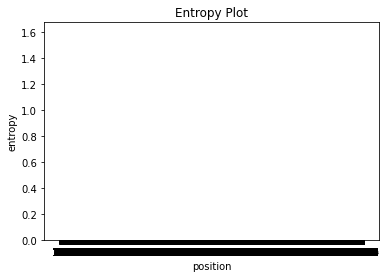

<Figure size 432x288 with 0 Axes>

In [7]:
# #按照reads计算熵值,画柱状图并且加上所有位点包括没有在vcf里出现的
# import csv
# import os
# import math
# import matplotlib.pyplot as plt
# all_csv_list = []
# prj_list = os.listdir('/mnt/alamo01/users/yangjingqi/01pipeline/01filtered_csv_deep_sample')

# for i in prj_list:
#     list_site_reads_num = []
#     prj_path = f'/mnt/alamo01/users/yangjingqi/01pipeline/01filtered_csv_deep_sample/{i}'
#     csv_list = os.listdir(prj_path)
#     for n in csv_list:
#         csv_path = f'{prj_path}/{n}'
#         all_csv_list.append(csv_path)
        
        
        
# for n in all_csv_list:
#     with open(csv_path) as csvfile:
#         csv_reader = csv.reader(csvfile)  
#         for row in csv_reader:
#             if row[0] != 'mutation':
#                 site_pos = row[0].split('_')[1]
#                 ref = row[0].split('_')[0]
#                 alt = row[0].split('_')[2]
#                 if site_pos not in list_site_reads_num:
#                     list_site_reads_num.append(site_pos)
# dict_site_reads_num = dict.fromkeys(list_site_reads_num)
# for k,v in dict_site_reads_num.items():
#     dict_site_reads_num[k] = {}



# for k,v in dict_site_reads_num.items():  
#     for n in csv_list:
#         csv_path = f'{prj_path}/{n}'
#         with open(csv_path) as csvfile:
#             csv_reader = csv.reader(csvfile)  
#             for row in csv_reader:
#                 if row[0] != 'mutation':
#                     site_pos = row[0].split('_')[1]
#                     ref = row[0].split('_')[0]
#                     alt = row[0].split('_')[2]
#                     ref_num = int(row[2])
#                     alt_num = int(row[1])
#                     if k == site_pos:
#                         if ref not in dict_site_reads_num[k]:
#                             dict_site_reads_num[k][ref] = ref_num
#                         else:
#                             dict_site_reads_num[k][ref] += ref_num
#                         if alt not in dict_site_reads_num[k]:
#                             dict_site_reads_num[k][alt] = alt_num
#                         else:
#                             dict_site_reads_num[k][alt] += ref_num
# # print(dict_site_reads_num)

# dict_eachsite_entropy = {}
# for k,v in dict_site_reads_num.items():
#     each_site_all_reads = 0
#     h_all = 0
#     for j in v.keys():
#         each_site_all_reads += dict_site_reads_num[k][j]
#     for j in v.keys():
#         p = dict_site_reads_num[k][j]/each_site_all_reads
#         if p!= 0:
#             h = -p*math.log2(p)
#             h_all += h
#     dict_eachsite_entropy[k] = h_all
# dict_all_site = {}


# for s in range(1,15192):
#     s1 = str(s)
#     dict_all_site[s1] = 0
# for s,e in dict_all_site.items():
#     for d,p in dict_eachsite_entropy.items():
#         if s == d:
#             dict_all_site[s] = dict_eachsite_entropy[s]


# # print(i)
# # print(dict_eachsite_entropy)
# list_entropy =list(dict_all_site.values())
# list_position = list(dict_all_site.keys())
# # print(list_entropy)
# # print(list_position)
# plt.bar(list_position, list_entropy)
# plt.xlabel('position')
# plt.ylabel('entropy')
# plt.title('Entropy Plot')
# plt.show()
# plt.savefig(f'/mnt/alamo01/users/yangjingqi/01pipeline/10entropy/entropy.pdf')




In [ ]:
#下面是不分城市的

In [ ]:
import os
city_list = os.listdir('/mnt/alamo01/users/yangjingqi/01pipeline/vcf_pair')
for i in city_list:
    city_path = f'/mnt/alamo01/users/yangjingqi/01pipeline/vcf_pair/{i}'
    vcf_list = os.listdir(city_path)
    for n in vcf_list:
        vcf_path = f'{city_path}/{n}'
        os.system(f'cp {vcf_path} /mnt/alamo01/users/yangjingqi/02pipeline_all/vcf_pair')


In [ ]:
#05 统计bayes的每个样本reads数，写成A256G的形式，过滤，只过滤测序深度,不过滤频率。
#统计每个样本的突变数量
#dp>100并且在至少2个样本中出现过的才算。
#变异类型是snp或者del或ins，这里也筛选了。
#最终输出csv文件。

import csv
import os
import vcf
bayes_filenames=os.listdir('/mnt/alamo01/users/yangjingqi/02pipeline_all/vcf_pair')
type_list= []
dict_mut_num = {}#在几个样本中出现过。形成列表，在列表中的才算真正的突变。
#找出突变在几个样本中出现
for i in bayes_filenames:
    if i.endswith('vcf'):
        i_1 = i.split('.')[0]
        reads_pos_dict = {}
        path1 = '/mnt/alamo01/users/yangjingqi/02pipeline_all/vcf_pair'+'/'+i
        try:
            vcf_reader = vcf.Reader(filename=path1)
            for record in vcf_reader:
    #             print(record)
    #             print(record.INFO)

                alt_count = record.INFO['AO']
                ref_count = record.INFO['RO']
                ref = str(record).split(',')[2].split('=')[1]
                type0 = record.INFO['TYPE']
                position = str(record).split(',')[1].split('=')[1]
                dp = record.INFO['DP']
                if type0 not in type_list:
                    type_list.append(type0)
                for i in range(0,len(record.INFO['TYPE'])):
                    alt1 = str(record).split('=')[4].replace(')','').replace('[','').replace(']','').replace(' ','')
                    alt2 = alt1.split(",")#转成列表,碱基
                    type2 = record.INFO['TYPE'][i]
                    info = f'{ref}_{position}_{alt2[i]}'
                    alt_count1 = alt_count[i]
                    af = record.INFO['AO'][i]/(record.INFO['AO'][i] + record.INFO['RO'])
    #                 print(af)
                    if dp > 100:
    #                     reads_pos_dict[info] = {'alt':alt_count1,'ref':ref_count,'type':type2,'allele_frequency':af}
                        if info not in dict_mut_num:
                            dict_mut_num[info] = 1
                        else:
                            dict_mut_num[info] += 1
#         print(reads_pos_dict)
        except Exception as e:
            print(f"Error: {e},{path1}")
            



filtered_list = []# 测序深度>100且出现在至少2个样本中的突变。
for k,v in dict_mut_num.items():
    if v > 1:
        filtered_list.append(k)
# print(filtered_list)


#根据filtered_list筛选突变，输出csv。
for i in bayes_filenames:
    if i.endswith('vcf'):
        i_1 = i.split('.')[0]
        reads_pos_dict = {}
        path1 = '/mnt/alamo01/users/yangjingqi/02pipeline_all/vcf_pair'+'/'+i
        try:
            vcf_reader = vcf.Reader(filename=path1)
            for record in vcf_reader:
    #             print(record)
    #             print(record.INFO)

                alt_count = record.INFO['AO']
                ref_count = record.INFO['RO']
                ref = str(record).split(',')[2].split('=')[1]
                type0 = record.INFO['TYPE']
                position = str(record).split(',')[1].split('=')[1]
                dp = record.INFO['DP']
                if type0 not in type_list:
                    type_list.append(type0)
                for i in range(0,len(record.INFO['TYPE'])):
                    alt1 = str(record).split('=')[4].replace(')','').replace('[','').replace(']','').replace(' ','')
                    alt2 = alt1.split(",")#转成列表,碱基
                    type2 = record.INFO['TYPE'][i]
                    info = f'{ref}_{position}_{alt2[i]}'
                    alt_count1 = alt_count[i]
                    af = record.INFO['AO'][i]/(record.INFO['AO'][i] + record.INFO['RO'])    
                    if dp > 100:#即使有列表了也还是需要测序深度>100的这个条件，不然有可能是出现在样本多但是测序深度不行的。
                        if info in filtered_list:
                            if type2 == 'snp' or type2 == 'del' or type2 == 'ins':#筛选变异类型
                                reads_pos_dict[info] = {'alt':alt_count1,'ref':ref_count,'type':type2,'allele_frequency':af,'sample_exist':dict_mut_num[info]}
    #         print(reads_pos_dict)
        except Exception as e:
            print(f"Error: {e},{path1}")
                      
        with open(f'/mnt/alamo01/users/yangjingqi/02pipeline_all/01filtered_csv_deep_sample/{i_1}.csv','w') as f:#表格可以加个频率
            writer = csv.writer(f)
            writer.writerow(["mutation","alt_reads","ref_reads","type","app","allele_frequency","sample_exist'"])
            for k,v in reads_pos_dict.items():
                writer.writerow([k,v['alt'],v['ref'],v['type'],'freebayes',v['allele_frequency'],v['sample_exist']])

In [ ]:
#06频率要5——80%的和上面不同。
# 统计bayes的每个样本reads数，写成A256G的形式，过滤，只过滤测序深度,不过滤频率。
#统计每个样本的突变数量
#dp>100并且在至少2个样本中出现过的才算。
#变异类型是snp或者del或ins，这里也筛选了。
#最终输出csv文件。

import csv
import os
import vcf
bayes_filenames=os.listdir('/mnt/alamo01/users/yangjingqi/02pipeline_all/vcf_pair')
type_list= []
dict_mut_num = {}#在几个样本中出现过。形成列表，在列表中的才算真正的突变。
#找出突变在几个样本中出现
for i in bayes_filenames:
    if i.endswith('vcf'):
        i_1 = i.split('.')[0]
        reads_pos_dict = {}
        path1 = '/mnt/alamo01/users/yangjingqi/02pipeline_all/vcf_pair'+'/'+i
        try:
            vcf_reader = vcf.Reader(filename=path1)
            for record in vcf_reader:
    #             print(record)
    #             print(record.INFO)

                alt_count = record.INFO['AO']
                ref_count = record.INFO['RO']
                ref = str(record).split(',')[2].split('=')[1]
                type0 = record.INFO['TYPE']
                position = str(record).split(',')[1].split('=')[1]
                dp = record.INFO['DP']
                if type0 not in type_list:
                    type_list.append(type0)
                for i in range(0,len(record.INFO['TYPE'])):
                    alt1 = str(record).split('=')[4].replace(')','').replace('[','').replace(']','').replace(' ','')
                    alt2 = alt1.split(",")#转成列表,碱基
                    type2 = record.INFO['TYPE'][i]
                    info = f'{ref}_{position}_{alt2[i]}'
                    alt_count1 = alt_count[i]
                    af = record.INFO['AO'][i]/(record.INFO['AO'][i] + record.INFO['RO'])
    #                 print(af)
                    if dp > 100:
    #                     reads_pos_dict[info] = {'alt':alt_count1,'ref':ref_count,'type':type2,'allele_frequency':af}
                        if info not in dict_mut_num:
                            dict_mut_num[info] = 1
                        else:
                            dict_mut_num[info] += 1
    #         print(reads_pos_dict)
        except Exception as e:
            print(f"Error: {e},{path1}")
                      


filtered_list = []# 测序深度>100且出现在至少2个样本中的突变。
for k,v in dict_mut_num.items():
    if v > 1:
        filtered_list.append(k)
# print(filtered_list)


#根据filtered_list筛选突变，输出csv。
for i in bayes_filenames:
    if i.endswith('vcf'):
        i_1 = i.split('.')[0]
        reads_pos_dict = {}
        path1 = '/mnt/alamo01/users/yangjingqi/02pipeline_all/vcf_pair'+'/'+i
        try:
            vcf_reader = vcf.Reader(filename=path1)
            for record in vcf_reader:
    #             print(record)
    #             print(record.INFO)

                alt_count = record.INFO['AO']
                ref_count = record.INFO['RO']
                ref = str(record).split(',')[2].split('=')[1]
                type0 = record.INFO['TYPE']
                position = str(record).split(',')[1].split('=')[1]
                dp = record.INFO['DP']
                if type0 not in type_list:
                    type_list.append(type0)
                for i in range(0,len(record.INFO['TYPE'])):
                    alt1 = str(record).split('=')[4].replace(')','').replace('[','').replace(']','').replace(' ','')
                    alt2 = alt1.split(",")#转成列表,碱基
                    type2 = record.INFO['TYPE'][i]
                    info = f'{ref}_{position}_{alt2[i]}'
                    alt_count1 = alt_count[i]
                    af = record.INFO['AO'][i]/(record.INFO['AO'][i] + record.INFO['RO'])    
                    if dp > 100:#即使有列表了也还是需要测序深度>100的这个条件，不然有可能是出现在样本多但是测序深度不行的。
                        if 0.05<af<0.8:#过滤频率。
                            if info in filtered_list:
                                if type2 == 'snp' or type2 == 'del' or type2 == 'ins':#筛选变异类型
                                    reads_pos_dict[info] = {'alt':alt_count1,'ref':ref_count,'type':type2,'allele_frequency':af,'sample_exist':dict_mut_num[info]}
        #         print(reads_pos_dict)
        except Exception as e:
            print(f"Error: {e},{path1}")
                                  
        with open(f'/mnt/alamo01/users/yangjingqi/02pipeline_all/02filter_csv_005_08/{i_1}.csv','w') as f:#表格可以加个频率
            writer = csv.writer(f)
            writer.writerow(["mutation","alt_reads","ref_reads","type","app","allele_frequency","sample_exist'"])
            for k,v in reads_pos_dict.items():
                writer.writerow([k,v['alt'],v['ref'],v['type'],'freebayes',v['allele_frequency'],v['sample_exist']])

In [22]:
#03.1 005_08,mutation_sample heatmap
#获取所有突变的列表，过滤后的,类型和深度都过滤了。变异类型也过滤了，这部分代码里也有过滤snp,del的（其实不需要了，因为csv里只有snp,del)。
import os
import pandas as pd
import csv
list_mutation = []
sample_list = []
file_bayes_listdir = os.listdir('/mnt/alamo01/users/yangjingqi/02pipeline_all/02filter_csv_005_08/')

for i in file_bayes_listdir:
    if i.endswith('csv'):
#         if i.startswith('rsv'):
        sample_list.append(i)
        path_csv_bayes = f'/mnt/alamo01/users/yangjingqi/02pipeline_all/02filter_csv_005_08/{i}'
        with open(path_csv_bayes) as csvfile:
            csv_reader = csv.reader(csvfile)  
            for row in csv_reader:
                if row[0] != 'mutation':
                    list_mutation.append(row[0])
    #         print(list_mutation_eachsample)
#             for m in list_mutation_eachsample:
#                 if m not in list_mutation:
#                     list_mutation.append(m)
#建立字典，突变对应的样本，0为没有，1为有。
mutation_sample = dict.fromkeys(list_mutation)#列表转为key
# print(mutation_sample)
# print(sample_list)
for k in mutation_sample.keys():
    mutation_sample[k] = dict.fromkeys(sample_list)
# print(mutation_sample)
for i in file_bayes_listdir:
    if i.endswith('csv'):
#         if i.startswith('rsv'):
        path_csv_bayes = f'/mnt/alamo01/users/yangjingqi/02pipeline_all/02filter_csv_005_08/{i}'  
        df_bayes = pd.read_csv(path_csv_bayes,encoding= 'utf-8')
        list_mutation_eachsample_both = list(df_bayes['mutation'])

        for k in mutation_sample.keys():
            if k in list_mutation_eachsample_both:
                mutation_sample[k][i] = 1
            else:
                mutation_sample[k][i] = 0
# print(mutation_sample)                
#写入csv
with open(f'/mnt/alamo01/users/yangjingqi/02pipeline_all/05heatmap_isnv/05heatmap_isnv.csv','w') as f:
    writer = csv.writer(f)
    firstrow = sample_list
    firstrow.sort()
    firstrow.insert(0,'mutation')#不要加mutation，但是那一个空格要怎么输入呢
    writer.writerow(firstrow)
    
    for k,v in mutation_sample.items():
        row = []
        row_group = []
        for m in v.keys():
            m1 = m.split('.')[0]
            row.append(m)
            row.sort()
        for n in row:
            row_group.append(v[n])
        row_group.insert(0,k)
        # print(row)
        writer.writerow(row_group)
###为什么会有哪个样本中都不存在的突变？因为上面字典名字sra写成bayes了。
        

In [25]:
#04统计突变类型，3%-80%和80%以上的比例，先不管allele frequency，只看次数
#二代测序中3%-80%的突变，对频率有错误影响，对蛋白分布没有影响。可以加一列属于哪个样本的。加上了，次数是准的了。

#80%以下：
import os
import csv
dict_003_08_next_generation = {}
for i in os.listdir('/mnt/alamo01/users/yangjingqi/02pipeline_all/01filtered_csv_deep_sample'):
    if i.endswith('.csv'):
        csv_path = f'/mnt/alamo01/users/yangjingqi/02pipeline_all/01filtered_csv_deep_sample/{i}'
        with open(csv_path) as csvfile:
            csv_reader = csv.reader(csvfile)  
            for row in csv_reader:
                if row[0] != 'mutation':
                    first = row[0].split('_')[0]
#                     last = row[0].split('_')[2]
#                     position = row[0].split('_')[1]
                    frequnecy = float(row[5])
                    mutation = row[0]
                    type1 = row[3]
                    if 0.03 <= frequnecy <= 0.8:
#                         if len(first) == 1:#找的snv很奇怪，明明是单个突变非要写一堆，所以就不用type筛选了。
#                             dict_003_08_next_generation[mutation] = frequnecy
                        if mutation not in dict_003_08_next_generation.keys():
                            dict_003_08_next_generation[mutation] = {}
                            dict_003_08_next_generation[mutation][i] = [frequnecy,type1]
                        else:#一定要加，不然每次都是赋值一个空字典就没办法新加进来样本。
                            dict_003_08_next_generation[mutation][i] = [frequnecy,type1]
# ----------------------------------------------------------------------------------------------------------    
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!统计所有的突变及其数量，频率。 后面看在哪个突变上要用。             
with open('/mnt/alamo01/users/yangjingqi/02pipeline_all/06product_exist/06isnv_mutation.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(['isnv','sample','frequency','type'])
    for k,v in dict_003_08_next_generation.items():
        for s,info in v.items():
            frequency = info[0]
            type3 = info[1]
            writer.writerow([k,s.split('.')[0],frequency,type3])
            
#-----------------------------------------------------------------------------------------------------------
    
#统计数量
dict_num_mutation = {'A_G':0,'A_T':0,'A_C':0,'G_A':0,'G_C':0,'G_T':0,'T_C':0,'T_A':0,'T_G':0,'C_A':0,'C_T':0,'C_G':0,'del':0,'ins':0}
for k,v in dict_003_08_next_generation.items():
    ref = k.split('_')[0]
    alt = k.split('_')[2]
    for s in v.values():
        type2 = s[1]
#         print(type2)
    if type2 =='snp':
        name = f'{ref}_{alt}'
        add_count = len(v)
    #     print(name)
        for m,c in dict_num_mutation.items():
            if name == m:
                dict_num_mutation[m] += add_count  #!!!赋值不可以只写c，一定要写成键的值。
    if type2 =='del':
        add_count = len(v)
        
        dict_num_mutation['del'] += add_count
    if type2 =='ins':
        add_count = len(v)
        
        dict_num_mutation['ins'] += add_count
            
            
        
print(dict_num_mutation)
count_all = 0
for k,v in dict_num_mutation.items():
    count_all += v
print(count_all)
dict_proportion =  dict.fromkeys(dict_num_mutation.keys())
for k in dict_proportion.keys():
    dict_proportion[k] = {}
    dict_proportion[k]['count'] = dict_num_mutation[k]
    dict_proportion[k]['proportion'] = dict_proportion[k]['count']/count_all
print(dict_proportion)  
with open("/mnt/alamo01/users/yangjingqi/02pipeline_all/07mutation_proportion/07isnv_mutation_type.csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(['mutation_type','count','proportion','group'])
    for k,v in dict_proportion.items():
        writer.writerow([k,v['count'],v['proportion'],'iSNV'])
        
        
        
        
        
        
# #-----------------------------------------------------------------------
# #80%上：
dict_003_08_next_generation = {}
for i in os.listdir('/mnt/alamo01/users/yangjingqi/02pipeline_all/01filtered_csv_deep_sample'):
    if i.endswith('.csv'):
        csv_path = f'/mnt/alamo01/users/yangjingqi/02pipeline_all/01filtered_csv_deep_sample/{i}'
        with open(csv_path) as csvfile:
            csv_reader = csv.reader(csvfile)  
            for row in csv_reader:
                if row[0] != 'mutation':
                    first = row[0].split('_')[0]
#                     last = row[0].split('_')[2]
#                     position = row[0].split('_')[1]
                    frequnecy = float(row[5])
                    mutation = row[0]
                    type1 = row[3]
                    if  frequnecy > 0.8:
#                         if len(first) == 1:#找的snv很奇怪，明明是单个突变非要写一堆，所以就不用type筛选了。
#                             dict_003_08_next_generation[mutation] = frequnecy
                        if mutation not in dict_003_08_next_generation.keys():
                            dict_003_08_next_generation[mutation] = {}
                            dict_003_08_next_generation[mutation][i] = [frequnecy,type1]
                        else:#一定要加，不然每次都是赋值一个空字典就没办法新加进来样本。
                            dict_003_08_next_generation[mutation][i] = [frequnecy,type1]

#统计数量
dict_num_mutation = {'A_G':0,'A_T':0,'A_C':0,'G_A':0,'G_C':0,'G_T':0,'T_C':0,'T_A':0,'T_G':0,'C_A':0,'C_T':0,'C_G':0,'del':0,'ins':0}
for k,v in dict_003_08_next_generation.items():
    ref = k.split('_')[0]
    alt = k.split('_')[2]
    for s in v.values():
        type2 = s[1]
#         print(type2)
    if type2 =='snp':
        name = f'{ref}_{alt}'
        add_count = len(v)
    #     print(name)
        for m,c in dict_num_mutation.items():
            if name == m:
                dict_num_mutation[m] += add_count  #!!!赋值不可以只写c，一定要写成键的值。
    if type2 =='del':
        add_count = len(v)
        
        dict_num_mutation['del'] += add_count
    if type2 =='ins':
        add_count = len(v)
        
        dict_num_mutation['ins'] += add_count
            
            
        
# print(dict_num_mutation)

#算比例的分母
count_all = 0
for k,v in dict_num_mutation.items():
    count_all += v
# print(count_all)
dict_proportion =  dict.fromkeys(dict_num_mutation.keys())
for k in dict_proportion.keys():
    dict_proportion[k] = {}
    dict_proportion[k]['count'] = dict_num_mutation[k]
    dict_proportion[k]['proportion'] = dict_proportion[k]['count']/count_all
print(dict_proportion)  
with open("/mnt/alamo01/users/yangjingqi/02pipeline_all/07mutation_proportion/07snp_mutation_type.csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(['mutation_type','count','proportion','group'])
    for k,v in dict_proportion.items():
        writer.writerow([k,v['count'],v['proportion'],'SNP'])
        
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!统计所有的突变及其数量，频率。 后面看在哪个突变上要用。             
with open('/mnt/alamo01/users/yangjingqi/02pipeline_all/06product_exist/06snp_mutation.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(['isnv','sample','frequency','type'])
    for k,v in dict_003_08_next_generation.items():
        for s,info in v.items():
            frequency = info[0]
            type3 = info[1]
            writer.writerow([k,s.split('.')[0],frequency,type3])
            
            
            

{'A_G': 21313, 'A_T': 23235, 'A_C': 15150, 'G_A': 33560, 'G_C': 11344, 'G_T': 37206, 'T_C': 27195, 'T_A': 32394, 'T_G': 21939, 'C_A': 33801, 'C_T': 40464, 'C_G': 10167, 'del': 50941, 'ins': 7631}
366340
{'A_G': {'count': 21313, 'proportion': 0.058178195119288095}, 'A_T': {'count': 23235, 'proportion': 0.06342468744881803}, 'A_C': {'count': 15150, 'proportion': 0.04135502538625321}, 'G_A': {'count': 33560, 'proportion': 0.09160888791832723}, 'G_C': {'count': 11344, 'proportion': 0.030965769503739696}, 'G_T': {'count': 37206, 'proportion': 0.10156139105748758}, 'T_C': {'count': 27195, 'proportion': 0.07423431784680898}, 'T_A': {'count': 32394, 'proportion': 0.08842605230114102}, 'T_G': {'count': 21939, 'proportion': 0.059886990227657366}, 'C_A': {'count': 33801, 'proportion': 0.09226674673800295}, 'C_T': {'count': 40464, 'proportion': 0.11045476879401649}, 'C_G': {'count': 10167, 'proportion': 0.027752907135447945}, 'del': {'count': 50941, 'proportion': 0.1390538843697112}, 'ins': {'coun

In [4]:
#加入每个突变的样本数量
# 05 翻译蛋白质，要加3-80%的。isnv的
#非同义氨基酸突变的具体情况和不同蛋白非同义突变的数量。
#插入没加先。
import csv
import pandas as pd
from Bio.Seq import Seq
dict_info = {}
info_list = []
dict_pep_cds = {'266_21555':'ORF1ab','21563_25384':"S",'25393_26220':"ORF3a",'26245_26472':"E",'26523_27191':"M",'27202_27387':"ORF6",'27394_27759':"ORF7a",'27756_27887':"ORF7b",'27894_28259':"ORF8",'28274_29533':"N",'29558_29674':"ORF10"}

#dict_pep_cds = {'99_518':'NS1_1C','628_1002':"NS2_1B",'1140_2315':"N",'2348_3073':"P",'3233_4003':"M",'4274_4468':"SH",'4659_5555':"G",'5632_7356':"F",'7576_8160':"M2",'8468_14965':"L"}
with open('/mnt/alamo01/users/yangjingqi/02pipeline_all/06product_exist/06isnv_mutation.csv') as csvfile:
    csv_reader = csv.reader(csvfile)  
    for row in csv_reader:
        if row[0] != 'isnv':
            mut = row[0]
            if mut not in info_list:
                info_list.append(mut)
dict_info = dict.fromkeys(info_list)


for i in dict_info.keys():#嵌套字典可以这样赋值：1、dict_info = dict.fromkeys(info_list)2、每个键都赋值成空字典，再正常加就好了
    dict_info[i] = {}
#新加的，统计每个突变的样本数量。
df = pd.read_csv('/mnt/alamo01/users/yangjingqi/02pipeline_all/06product_exist/06isnv_mutation.csv')
df_counts = df.isnv.value_counts()
# print(df_counts)
outputpath=f'/mnt/alamo01/users/yangjingqi/02pipeline_all/06product_exist/mut_sample_number.csv'
df_counts.to_csv(outputpath,sep=',',index=True,header=False)

dict_mut_num = {}

mut_number_path = f'/mnt/alamo01/users/yangjingqi/02pipeline_all/06product_exist/mut_sample_number.csv'
with open(mut_number_path) as csvfile:
    csv_reader = csv.reader(csvfile) 
    for row in csv_reader:
        isnv = row[0]
        num = row[1]
        dict_mut_num[isnv] = num    

    
with open('/mnt/alamo01/users/yangjingqi/02pipeline_all/06product_exist/06isnv_mutation.csv') as csvfile:
    csv_reader = csv.reader(csvfile)  
    for row in csv_reader:
        if row[0] != 'isnv':
            mut = row[0]
            pos = int(row[0].split('_')[1])
            fre = float(row[2])
            type4 = row[3]
            first = row[0].split('_')[0]
            last = row[0].split('_')[2]
            #分一下位置，del和ins的有可能结束位置和开始位置不在同一段蛋白里面。不太可能
            if type4 == 'del':#按照突变前的长度算
                pos_end = pos + len(first) -1
            if type4 == 'ins':#按照突变后的长度算
                pos_end = pos + len(last) -1          
            for k,v in dict_pep_cds.items():
                start = int(k.split('_')[0])
                end = int(k.split('_')[1])
                if type4 == 'snp':
                    if start <= pos <= end: #这里一定要转化成int，不然就是字符串是不对的。    
                        dict_info[mut]['product'] = v
                        dict_info[mut]['type'] = type4
                        dict_info[mut]['start'] = start
                        dict_info[mut]['end'] = end
                        dict_info[mut]['sample_number'] = dict_mut_num[mut]
#                         dict_info[mut]['frequency'] = fre 频率先不考虑了，有好多样本的
                if type4 == 'del' or type4 == 'ins':
                    if start <= pos <= end and start <= pos_end <= end: #这里一定要转化成int，不然就是字符串是不对的。    
                        dict_info[mut]['product'] = v
                        dict_info[mut]['type'] = type4
                        dict_info[mut]['start'] = start
                        dict_info[mut]['end'] = end
                        dict_info[mut]['sample_number'] = dict_mut_num[mut]
#                         dict_info[mut]['frequency'] = fre

                                       
# print(dict_info)
#去除不在cds范围内的碱基突变                   
dict_info_feikong = {}            
for i in dict_info.keys():
    if dict_info[i]:
        dict_info_feikong[i] = dict_info[i]
# print(dict_info_feikong)

#获取突变前后的三个碱基，蛋白位置不知道，可以用什么蛋白
dict_aa_mut = {}#非同义突变的字典
dict_aa_synonymous_mut = {}
ref_seq ='ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGACACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTCTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTCAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACAAAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCAGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTATTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGTCTGGTTTTAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTACTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGACACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACCTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGAGTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAAAGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTGAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTAATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGATGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAACATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTACTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCAGTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCATCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGGAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCCAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCAGTAGGGGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTATCCCCATGTGATTTTAATAGCTTCTTAGGAGAATGACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'
#ref_seq = 'ACGCGAAAAAATGCGTACAACAAACTTGCGTAAACCAAAAAAATGGGGCAAATAAGAATTTGATAAGTACCACTTAAATTTAACTCCCTTGGTTAGAGATGGGCAGCAATTCATTGAGTATGATAAAAGTTAGATTACAAAATTTGTTTGACAATGATGAAGTAGCATTGTTAAAAATAACATGCTATACTGACAAATTAATACATTTAACTAATGCATTGGCTAAGGCAGTGATACATACAATCAAATTGAATGGCATTGTATTTGTGCATGTTATTACAAGTAGTGATATTTGCCCTAATAATAATATTGTAGTGAAATCCAATTTCACAACAATGCCAGTGTTACAAAATGGAGGTTATATATGGGAAATGATGGAATTAACACACTGCTCTCAACCTAATGGCCTAATAGATGACAATTGTGAAATTAAATTCTCCAAAAAACTAAGTGATTCAACAATGACCAATTATATGAATCAATTATCTGAATTACTTGGATTTGATCTTAATCCATAAATTATAATAAATATCAACTAGCAAATCAATGTCACTAACACCATTAGTTAATATAAAACTTGACAGAAGATAAAAATGGGGCAAATAAATCAATTCAGCCGACCCAACCATGGACACAACACACAATGACACCACACCACAAAGACTGATGATCACAGACATGAGACCATTGTCACTTGAGACTATAATAATATCACTAACCAGAGACATCATAACACACAGATTTATATACTTGATAAATCATGAATGTATAGTGAGAAAACTTGATGAAAGACAGGCCACATTTACATTCCTGGTCAACTATGAAATGAAACTATTGCACAAAGTGGGAAGCACTAAATACAAAAAATATACTGAATACAACACAAAATATGGCACTTTTCCTATGCCAATATTTATCAATCATGATGGGTTCTTAGAATGCATTGGCATTAAGCCTACAAAGCACACTCCCATAATATACAAGTATGATCTCAATCCATGAATTTCAACACAAGAGTCACACAATCTGAAATAACAACTTCATGCATAACCACACTCCATAGTTCAAATGGAGCCTGAAAATTATAGTAATTTAAAATTAAGGAGAGACATAAGATGAAAGATGGGGCAAATACAAAAATGGCTCTTAGCAAAGTCAAGTTGAATGATACACTCAACAAAGATCAACTTCTGTCATCCAGCAAATACACCATCCAACGGAGCACAGGAGATAGTATTGATACTCCTAATTATGATGTGCAGAAACACATCAATAAGTTATGTGGCATGTTATTAATCACAGAAGATGCTAATCATAAATTCACTGGGTTAATAGGTATGTTATATGCTATGTCTAGATTAGGAAGAGAAGACACCATAAAAATACTCAGAGATGCGGGATATCATGTAAAAGCAAATGGAGTGGATGTAACAACACATCGTCAAGATATTAATGGGAAAGAAATGAAATTTGAAGTGTTAACATTGTCAAGCTTAACAACTGAAATTCAAATCAACATTGAGATAGAATCTAGAAAATCCTACAAAAAAATGCTAAAAGAAATGGGAGAGGTAGCTCCAGAATACAGGCATGACTCTCCTGATTGTGGGATGATAATATTATGTATAGCGGCATTAGTAATAACCAAATTAGCAGCAGGGGATAGATCTGGTCTTACAGCTGTGATTAGGAGGGCTAATAATGTCCTAAAAAATGAAATGAAACGTTATAAAGGCTTACTACCCAAGGATATAGCCAACAGCTTCTATGAAGTGTTTGAAAAATATCCTCACTTTATAGATGTTTTTGTTCATTTTGGTATAGCACAATCTTCTACCAGAGGTGGCAGTAGAGTTGAAGGGATTTTTGCTGGATTGTTTATGAATGCCTATGGTGCAGGGCAAGTGATGTTACGGTGGGGGGTCTTAGCAAAATCAGTTAAAAATATTATGCTAGGACACGCTAGTGTGCAAGCAGAAATGGAACAAGTTGTGGAGGTTTATGAATATGCCCAAAAATTGGGTGGAGAAGCAGGGTTCTACCATATATTGAACAACCCAAAAGCATCATTATTGTCTTTGACTCAATTTCCTCACTTCTCCAGTGTAGTATTAGGCAATGCTGCTGGCCTAGGCATAATGGGAGAATACAGAGGTACACCAAGGAATCAAGATCTATATGATGCTGCAAAAGCATATGCTGAACAACTCAAAGAAAATGGTGTGATTAACTACAGTGTATTAGACTTGACAGCAGAAGAACTAGAGGCTATCAAACATCAGCTTAATCCAAAAGATAATGATGTAGAGCTTTGAGTTAATAAAAAAAATGGGGCAAATAAAACATCATGGAAAAGTTTGCTCCTGAATTCCATGGAGAAGATGCAAACAACAGAGCTACCAAATTCCTAGAATCAATAAAGGGCAAATTCACATCACCTAAAGATCCCAAGAAAAAAGATAGTATCATATCTGTCAACTCAATAGATATAGAAGTAACCAAAGAAAGCCCTATAACATCAAATTCAACCATTATAAACCCAACAAATGAGACAGATGATACTGTAGGGAACAAGCCCAATTATCAAAGAAAACCTCTAGTAAGTTTCAAAGAAGACCCTACGCCAAGTGATAATCCCTTTTCAAAACTATACAAAGAAACCATAGAAACATTTGATAACAATGAAGAAGAATCTAGCTATTCATATGAAGAAATAAATGATCAGACAAACGATAATATAACAGCAAGATTAGATAGGATTGATGAAAAATTAAGTGAAATACTAGGAATGCTTCACACATTAGTAGTAGCGAGTGCAGGACCTACATCTGCTCGGGATGGTATAAGAGATGCCATGGTTGGTTTAAGAGAAGACATGATAGAAAAAATCAGAACTGAAGCATTAATGACCAATGACAGACTAGAAGCTATGGCAAGACTCAGGAATGAGGAAAGTGAAAAGATGGCAAAAGACACATCAGATGAAGTGTCTCTCAATCCAACATCAGAGAAATTGAACAACCTGTTGGAAGGGAATGATAGTGACAATGATCTATCACTTGATGATTTCTGATCAGTTACCAATCTGTACATCAACACACAACACCAACAGAAGACCAACAAACAAACCAACTCACCCATCCAACCAAACATCTATACGCCAATCAGCCAATCCAAAACTAGCCACCCGGAAAAAATAGATACTATAGTTACAAAAAAAGATGGGGCAAATATGGAAACATACGTGAACAAACTTCACGAAGGCTCCACATACACAGCTGCTGTTCAATACAATGTCTTAGAAAAAGACGATGACCCTGCATCACTTACAATATGGGTGCCCATGTTCCAATCATCCATGCCAGCAGATTTACTTATAAAAGAACTAGCTAATGTCAACATACTAGTGAAACAAATATCCACACCCAATGGACCTTCATTAAGAGTCATGATAAACTCAAGAAGTGCAGTGCTAGCACAAATGCCCAGCAAATTTACCATATGTGCCAATGTGTCCTTGGATGAAAGAAGCAAGCTGGCATATGATGTAACCACACCCTGTGAAATCAAGGCATGTAGTCTAACATGCCTAAAATCAAAAAATATGTTAACTACAGTTAAAGATCTCACTATGAAAACACTCAACCCAACACATGACATCATTGCTTTATGTGAATTTGAAAATATAGTAACATCAAAAAAAGTCATAATACCAACATACCTAAGATCCATCAGTGTCAGAAATAAAGATCTGAACACACTTGAAAATATAACAACCACTGAATTCAAAAATGCCATCACAAATGCAAAAATCATCCCTTACTCAGGATTACTGTTAGTCATCACAGTGACTGACAACAAAGGAGCATTCAAATACATAAAGCCACAAAGTCAATTTATAGTAGATCTTGGAGCTTACCTAGAAAAAGAAAGTATATATTATGTTACAACAAATTGGAAGCACACAGCTACACGATTTGCAATCAAACCCATGGAAGATTAACCTTTTTCTTCTACATCAGTGAGTTGATTCATACAAACTTTCTACCTACATTCTTCACTTCACCATCATAATCACCAACCCTCTGTGGTTCAACTAATCAAACAAAACCCATCTGGAGCCTCAGATCATCCCAAGTCATTGTTCATCAGATCTAGTACTCAAATAAGTTAATAAAAATATCCACATGGGGCAAATAATCATTGGAGGAAATCCAACTAATCACAATATCTGTCAACATAGACAAGTCAACACGCCAGGCAAAATCAACCAATGGAAAATACATCCATAACAATAGAATTCTCAAGCAAATTCTGGCCTTACTTTACACTAATACACATGATAACAACAATAATCTCTTTGCTAATCATAATCTCCATCATGATTGCAATACTGAACAAACTCTGTGAATATAACGTATTCCATAACAAAACCTTTGAGCTACCAAGAGCTCGAGTCAATACATAGCATTCACCAATCTGATGGCACAAAACAGTAACCTTGCATTTGTAAGTGAACAACCCTCACCTCTTTACAAAACCACATCAACATCTCACCATGCAAGCCATCATCCATATTATAAAGTAGTTAATTAAAAATAATCATAACAATGAACTAAGATATTAAGACTAACAATAACGTTGGGGCAAATGCAAACATGTCCAAAAACAAGGACCAACGCACCACCAAGACACTAGAAAAGACCTGGGACACTCTCAATCATCTATTATTCATATCATCGTGCTTATACAAGTTAAATCTTAAATCTATAGCACAAATCACATTATCCATTCTGGCAATGATAATCTCAACTTCACTTATAATTGCAGCCATCATATTCATAGCCTCGGCAAACCACAAAGTCACACTAACAACTGCAATCATACAAGATGCAACAAGCCAGATCAAGAACACAACCCCAACATACCTCACCCAGAATCCCCAGCTTGGAATCAGCTTCTCCAATCTGTCTGAAACTACATCACAAACCACCACCATACTAGCTTCAACAACACCAAGTGTCAAGTCAACCCTGCAATCCACAACAGTCAAGACCAAAAACACAACAACAACCAAAATACAACCCAGCAAGCCCACCACAAAACAACGCCAAAACAAACCACCAAACAAACCCAATAATGATTTTCACTTTGAAGTGTTCAACTTTGTACCTTGCAGCATATGCAGCAACAATCCAACCTGCTGGGCTATCTGTAAAAGAATACCAAACAAAAAACCTGGAAAGAAAACCACCACCAAGCCCACAAAAAAACCAACCATCAAGACAACCAAAAAAGATCTCAAACCTCAAACCACAAAACCAAAGGAAGTACCTACCACCAAGCCCACAGAAAAGCCAACCATCAACACCACCAAAACAAACATCAGAACTACACTGCTCACCAACAATACCACAGGAAATCCAGAACACACAAGTCAAAAGGGAACCCTCCACTCAACCTCCTCCGATGGCAATCCAAGCCCTTCACAAGTCTATACAACATCCGAGTACCTATCACAACCTCCATCTCCATCCAACACAACAAACCAGTAGTCATTAAAAAGCGTATTATTGCAAAAAGCCATGACCAAATCAACCAGAATCAAAATCAACTCTGGGGCAAATAACAATGGAGTTGCCAATCCTCAAAACAAATGCAATTACCGCAATCCTTGCTGCAGTCACACTCTGTTTTGCTTCCAGTCAAAACATCACTGAAGAATTTTATCAAACAACATGCAGTGCAGTCAGCAAAGGCTATCTTAGTGCTCTAAGAACTGGTTGGTATACTAGTGTTATAACTATAGAATTAAGTAATATCAAGGAAAATAAGTGTAATGGAACAGACGCTAAGGTAAAATTGATAAAACAAGAATTAGATAAATATAAAAGTGCTGTAACAGAATTGCAGTTGCTCATGCAAAGCACACCGGCAACCAACAATCGAGCCAGAAGAGAACTACCAAGGTTTATGAATTATACACTCAACAATACCAAAAATACCAATGTAACATTAAGCAAGAAAAGGAAAAGAAGATTTCTTGGCTTTTTGTTAGGTGTTGGATCTGCAATCGCCAGTGGCATTGCTGTATCTAAGGTCCTGCACCTAGAAGGGGAAGTGAACAAAATCAAAAGTGCTCTACTATCCACAAACAAGGCTGTAGTCAGCTTATCAAATGGAGTTAGTGTCTTAACCAGCAAAGTGTTAGACCTCAAAAACTATATAGATAAACAGTTGTTACCTATTGTGAACAAGCAAAGCTGTAGCATATCAAACATTGAAACTGTGATAGAGTTCCAACAAAAGAACAACAGACTACTAGAGATTACCAGGGAATTTAGTGTTAATGCAGGTGTAACTACACCTGTAAGCACTTATATGTTAACAAATAGTGAATTATTATCATTAATCAATGATATGCCTATAACAAATGATCAGAAAAAGTTAATGTCCAACAATGTTCAAATAGTTAGACAGCAAAGTTACTCTATCATGTCCATAATAAAGGAGGAAGTCTTAGCATATGTAGTACAATTACCACTATATGGTGTAATAGATACACCTTGTTGGAAACTGCACACATCCCCTCTATGTACAACCAACACAAAGGAAGGGTCCAACATCTGTTTAACAAGAACCGACAGAGGATGGTACTGTGACAATGCAGGATCAGTATCTTTCTTCCCACTAGCTGAAACATGTAAAGTTCAATCGAATCGAGTATTTTGTGACACAATGAACAGTTTAACATTACCAAGTGAAGTAAATCTCTGCAACATTGACATATTCAACCCCAAATATGATTGCAAAATTATGACTTCAAAAACAGATGTAAGCAGCTCCGTTATCACATCTCTAGGAGCCATTGTGTCATGCTATGGCAAAACTAAATGTACAGCATCCAATAAAAATCGTGGAATCATAAAGACATTTTCTAACGGGTGCGATTATGTATCAAATAAGGGGGTTGACACTGTGTCTGTAGGTAATACATTATATTATGTAAATAAGCAAGAAGGCAAAAGTCTCTATGTAAAAGGTGAACCAATAATAAATTTCTATGACCCATTAGTGTTCCCCTCTGATGAATTTGATGCATCAATATCTCAAGTCAATGAGAAGATTAACCAGAGCCTAGCATTTATTCGTAAATCCGATGAATTATTACATAATGTAAATGCTGGTAAATCCACCATAAATATCATGATAACTACTATAATTATAGTGATTATAGTAATATTGTTATCATTAATTGCCGTTGGACTGCTCCTATACTGCAAGGCCAGAAGCACACCAGTCACACTAAGCAAGGATCAACTGAGTGGTATAAATAATATTGCATTTAGTAACTAAATAAAAATAGCACCTAATCATGTTCTTACAATGGTTTCATATCTGCTCATAGACAACCCATCTATCATTGGATTTTCTTAAAATCTGAACTTCATCGAAACTCTCATCTATAAACCATCTCACTTACATTATTTAAGTAGATTCCTAGTTTATAGTTATATAAAACAATTGAATACCAGATTAACTTACTATTTGTAAAAAATGAGAACTGGGGCAAATATGTCACGAAGGAATCCTTGCAAATTTGAAATTCGAGGTCATTGCTTGAATGGTAAGAGGTGTCATTTTAGTCATAATTATTTTGAATGGCCACCCCATGCACTGCTTGTAAGACAAAACTTTATGTTAAACAGAATACTTAAGTCTATGGATAAAAGCATCGATACTTTATCAGAAATAAGTGGAGCTGCAGAGTTGGACAGAACAGAAGAGTATGCCCTCGGTGTAGTTGGAGTGCTAGAGAGTTATATAGGATCTATAAATAATATAACTAAACAATCAGCATGTGTTGCCATGAGCAAACTCCTCACTGAACTCAACAGTGATGACATCAAAAAACTGAGGGACAATGAAGAGCCAAATTCACCCAAGATAAGAGTGTACAATACTGTCATATCATATATTGAAAGCAACAGGAAAAACAATAAACAAACTATCCATCTGTTAAAAAGATTGCCAGCAGACGTATTGAAGAAAACCATAAAAACCACATTGGATATCCACAAGAGCATAACCATCAATAACCCAAAAGAATCAACTGTTAGTGATATAAACGACCATGCCAAAAATAATGATACTACCTGACAAATATCCTTGTAGTATAAATTCCATACTAATAACAAGTAGTTGTAGAGTTACTATGTATAATCAAAAGAACACACTATATTTCAATCAAAACAACCAAAATAACCATATATACTCACCGAATCAACCATTCAATGAAATCCATTGGACCTCTCAAGACTTGATTGATGCAATTCAAAATTTTCTACAACATCTAGGTATTACTGATGATATATACACAATATATATATTAGTGTCATAACACTCAATCCTAATGCTTACCACATCATCAAACTATTAACTCAAACAATTCAAGCCATGGGACAAAATGGATCCCATTATTAATGGAAATTCTGCTAATGTGTATCTAACCGATAGTTATTTAAAAGGTGTTATTTCTTTCTCAGAATGTAATGCTTTAGGAAGTTACATATTCAATGGTCCTTATCTCAAAAATGATTATACCAACTTAATTAGTAGACAAAATCCATTAATAGAACACATAAATCTAAAGAAACTAAATATAACACAGTCCTTAATGTCTAAGTATCATAAAGGTGAAATAAAAATAGAAGAACCTACTTATTTTCAGTCATTACTTATGACATACAAGAGTATGACCTCGTTAGAACAGATTACTACCACTAATTTACTTAAAAAGATAATAAGAAGAGCTATAGAAATTAGTGATGTCAAAGTCTATGCTATATTGAATAAACTGGGGCTTAAAGAAAAAGACAAGATTAAATCCAACAATGGACAAGATGAAGACAACTCAGTTATTACAACCATAATCAAAGATGATATACTTTTAGCTGTTAAGGATAATCAATCTCATCTTAAAGCAGTCAAAAATCACTCTACAAAACAAAAAGATACAATCAAAACAACACTCTTGAAGAAATTAATGTGTTCAATGCAACATCCTCCATCATGGTTAATACATTGGTTTAATTTATACACAAAATTAAACAACATATTAACACAGTATCGATCAAGTGAGGTAAAAAACCATGGTTTTATATTGATAGACAATCATACTCTCAATGGATTCCAATTTATTTTGAATCAATATGGTTGTATAGTTTATCATAAGGAACTCAAAAGAATTACTGTGACAACCTATAATCAATTCTTGACATGGAAAAATATTAGCCTTAGTAGATTAAATGTTTGTTTAATTACATGGATTAGTAACTGTTTGAACACATTAAATAAAAGCTTAGGCTTAAGATGCGGATTCAATAATGTTATCTTGACACAACTATTCCTCTATGGAGATTGTATACTAAAACTATTCCACAATGAGGGGTTCTACATAATAAAAGAGGTAGAGGGATTTATTATGTCTCTAATTTTAAATATAACAGAAGAAGATCAATTCAGAAAACGGTTTTATAATAGTATGCTCAACAACATCACAGATGCTGCTAATAAAGCTCAGAAAAATCTGCTATCAAGAGTATGTCATACATTATTAGATAAGACAGTATCCGATAATATAATAAATGGCAGATGGATAATTCTATTAAGTAAGTTCCTTAAATTAATTAAGCTTGCAGGTGACAATAACCTTAACAATCTGAGTGAATTATATTTTTTGTTCAGAATATTTGGACACCCAATGGTAGATGAAAGACAAGCCATGGATGCTGTTAAAGTTAATTGCAACGAGACCAAATTTTACTTGTTAAGCAGTTTGAGTATGTTAAGAGGTGCCTTTATATATAGAATTATAAAAGGATTTGTAAATAATTACAACAGATGGCCTACTTTAAGGAATGCTATTGTTTTACCCTTAAGATGGTTAACTTACTATAAACTAAACACTTATCCTTCCTTGTTGGAACTTACAGAAAGAGATTTGATTGTTTTATCAGGACTACGTTTCTATCGTGAGTTTCGGTTGCCTAAAAAAGTGGATCTTGAAATGATCATAAATGATAAGGCTATATCACCTCCTAAAAATTTGATATGGACTAGTTTCCCTAGAAATTATATGCCGTCACACATACAAAATTATATAGAACATGAAAAATTAAAATTTTCCGAGAGTGATAAATCAAGAAGAGTATTAGAGTACTATTTAAGAGATAACAAATTCAATGAATGTGATTTATACAACTGTGTAGTTAATCAAAGTTATCTTAACAACCCTAATCATGTGGTATCTTTGACAGGCAAAGAAAGAGAACTCAGTGTAGGTAGAATGTTTGCAATGCAACCAGGAATGTTCAGACAAGTTCAAATATTAGCAGAGAAAATGATAGCTGAAAACATTTTACAATTCTTTCCTGAAAGTCTTACAAGATATGGTGATCTAGAACTACAGAAAATATTAGAATTGAAAGCAGGAATAAGTAACAAATCAAATCGTTACAATGATAATTACAACAATTACATTAGTAAGTGCTCTATCATCACAGATCTCAGCAAATTCAATCAAGCATTTCGATATGAAACATCATGTATTTGTAGTGATGTACTGGATGAACTGCATGGTGTACAATCTCTATTTTTCTGGTTACATTTAGCTATTCCTCATGTCACAATAATATGCACATATAGGCATGCACCCCCCTATATAAGAGATCATATTGTAGATCTTAACAATGTAGATGAACAAAGTGGATTATATAGATATCATATGGGTGGTATCGAAGGGTGGTGTCAAAAACTATGGACCATAGAAGCTATATCACTATTGGATCTAATATCTCTCAAAGGGAAATTCTCAATTACTGCTTTAATTAATGGTGACAATCAATCAATAGATATAAGTAAACCAGTCAGACTCATGGAAGGTCAAACTCATGCTCAAGCAGATTATTTGCTAGCATTAAATAGTCTTAAATTACTGTATAAAGAGTATGCAGGCATAGGCCACAAATTAAAAGGAACTGAGACTTATATATCAAGAGATATGCAATTTATGAGTAAAACAATTCAACATAACGGTGTATATTACCCAGCTAGTATAAAGAAAGTCCTAAGAGTGGGACCGTGGATAAACACTATACTTGATGATTTCAAAGTGAGTCTAGAATCTATAGGTAGTTTGACACAAGAATTAGAATATAGAGGAGAAAGTCTATTATGCAGTTTAATATTTAGAAATGTATGGTTATATAATCAAATTGCTTTACAACTAAAAAATCATGCATTATGTAACAATAAATTATATTTGGACATATTAAAGGTTCTGAAACACTTAAAAACCTTTTTTAATCTTGATAATATTGATACAGCATTAACATTGTATATGAATTTGCCCATGTTATTTGGTGGTGGTGATCCCAACTTGTTATATCGAAGTTTCTATAGAAGAACTCCTGATTTCCTCACAGAGGCTATAGTTCACTCTGTGTTCATACTTAGTTATTATACAAACCATGATTTAAAAGATAAACTTCAAGATCTGTCAGATGATAGATTGAATAAGTTCTTAACATGCATAATCACATTTGACAAAAACCCTAATGCTGAATTCGTAACATTGATGAGAGATCCTCAAGCTTTAGGGTCTGAGAGACAAGCTAAAATTACTAGCGAAATCAATAGACTGGCAGTTACTGAGGTTTTGAGCACAGCTCCAAACAAAATATTCTCCAAAAGTGCACAACACTATACCACTACAGAGATAGATCTAAATGATATTATGCAAAATATAGAACCTACATATCCTCACGGGCTAAGAGTTGTTTATGAAAGTTTACCCTTTTATAAAGCAGAGAAAATAGTAAATCTTATATCCGGTACAAAATCTATAACTAACATACTGGAAAAGACTTCTGCCATAGACTTAACAGATATTGATAGAGCCACTGAGATGATGAGGAAAAACATAACTTTGCTTATAAGGATATTTCCATTAGATTGTAACAGAGATAAAAGGGAAATATTGAGTATGGAAAACCTAAGTATTACTGAATTAAGCAAATATGTTAGGGAAAGATCTTGGTCTTTATCCAATATAGTTGGTGTTACATCACCTAGTATCATGTATACAATGGACATCAAATATACAACAAGCACTATAGCTAGTGGCATAATCATAGAGAAATATAATGTTAACAGTTTAACACGTGGTGAGAGAGGACCCACTAAACCATGGGTTGGTTCATCTACACAAGAGAAAAAAACAATGCCAGTTTATAATAGACAAGTTTTAACCAAAAAACAGAGAGATCAAATAGATCTATTAGCAAAATTGGATTGGGTGTATGCATCTATAGATAACAAGGATGAATTCATGGAAGAACTTAGCATAGGAATTCTTGGGTTAACATATGAGAAAGCCAAAAAATTATTTCCACAATATTTAAGTGTTAACTATTTGCATCGCCTTACAGTCAGTAGTAGACCATGTGAATTCCCTGCATCAATACCAGCTTATAGAACTACAAATTATCACTTTGATACTAGCCCTATTAATCGCATATTAACAGAAAAGTATGGTGATGAAGATATTGATATAGTATTCCAAAACTGTATAAGCTTTGGCCTTAGCTTAATGTCAGTAGTAGAACAATTTACTAATGTATGTCCTAACAGAATTATTCTTATACCTAAGCTTAATGAGATACATTTAATGAAACCTCCCATATTCACAGGTGATGTTGATATTCACAAGTTAAAACAAGTGATACAAAAACAGCATATGTTTTTACCAGACAAAATAAGTTTGACTCAATATGTGGAATTATTCTTAAGTAATAAAACACTCAAATCTGGATCTCATGTTAATTCTAATTTAATATTGGCGCATAAGATATCTGACTATTTTCATAATACTTACATTTTAAGTACTAATTTAGCTGGACATTGGATTCTGATTATACAACTTATGAAAGATTCTAAGGGTATTTTTGAAAAAGATTGGGGAGAGGGATATATAACTGATCATATGTTCATTAATTTGAAAGTTTTCTTCAATGCTTATAAGACCTATCTCTTGTGTTTTCATAAAGGTTACGGCAGAGCAAAGCTGGAGTGTGATATGAATACTTCAGATCTCCTATGTGTATTGGAATTAATAGACAGTAGTTATTGGAAGTCTATGTCTAAGGTATTTTTAGAACAAAAAGTTATCAAATACATTCTTAGCCAGGATGCAAGTTTACATAGAGTAAAAGGATGTCATAGCTTCAAACTATGGTTTCTTAAACGTCTTAATGTAGCAGAATTCACAGTTTGCCCTTGGGTTGTTAACATAGATTATCATCCAACACATATGAAAGCAATATTAACTTATATAGATCTTGTTAGAATGGGATTGATAAATATAGATAAAATATACATTAAAAATAAACACAAATTCAATGATGAATTTTATACTTCTAATCTCTTTTACATTAATTATAACTTCTCAGATAATACTCATCTATTAACTAAACATATAAGGATTGCTAATTCTGAATTAGAAAATAATTACAACAAATTATATCATCCTACACCAGAAACCCTAGAAAATATACTAACCAATCCGGTTAAATGTAATGACAAAAAGACACTGAATGACTATTGTATAGGTAAAAATGTTGACTCAATAATGTTACCATTGTTATCTAATAAGAAGCTTATTAAATCGCCTACAATGATTAGAACCAATTACAGCAAACAAGATTTGTATAATTTATTTCCTACGGTTGTGATTGATAAAATTATAGATCATTCAGGTAATACAGCCAAATCTAACCAACTTTACACTACTACTTCTCATCAAATACCTTTAGTGCACAATAGCACATCACTTTATTGCATGCTTCCTTGGCATCATATTAATAGATTCAATTTTGTATTTAGTTCTACAGGTTGTAAAATTAGTATAGAGTATATTTTAAAAGACCTTATAATTAAAGATCCTAATTGTATAGCATTCATAGGTGAAGGAGCAGGGAATTTATTATTGCGTACAGTAGTGGAACTTCATCCCGATATAAGATATATTTACAGAAGTCTGAAGGATTGCAATGATCATAGTTTACCTATTGAGTTTTTAAGGCTGTACAATGGACATATCAACATTGATTATGGTGAAAATTTGACCATTCCTGCTACAGATGCAACCAACAACATTCATTGGTCTTATTTACATATAAAGTTTGCTGAACCTATCAGTCTTTTTGTCTGTGATGCTGAATTGCCTGTAACAGTCAACTGGAGTAAAATTATAATAGAGTGGAGCAAGCATGTAAGAAAATGCAAGTACTGTTCCTCAGTTAATAAATGTACGTTAATAGTAAAATATCATGCTCAAGATGATATCGATTTCAAATTAGACAATATAACTATATTAAAAACTTATGTATGCTTAGGCAGTAAGTTAAAGGGGTCTGAAGTTTACTTAGTCCTTACAATAGGTCCTGCAAATGTGTTCCCAGTATTTAATGTAGTACAAAATGCTAAATTGATACTATCAAGAACCAAAAATTTCATCATGCCTAAGAAGGCTGATAAAGAGTCTATTGATGCAAATATTAAAAGTTTGATACCCTTTCTTTGTTACCCTATAACAAAAAAAGGAATTAATACTGCATTGTCAAAACTAAAGAGTGTTGTTAGTGGAGATATACTATCATATTCTATAGCAGGACGTAATGAAGTTTTCAGCAATAAACTTATAAATCATAAGCATATGAACATCTTAAAATGGTTCAATCATGTTTTAAATTTCAGATCAACAGAACTAAACTATAATCATTTATATATGGTAGAATCTACATATCCTTATCTAAGTGAATTGTTAAACAGCTTGACAACTAATGAACTTAAAAAACTGATTAAAATCACAGGTAGTTTGTTATACAACTTTCATAATGAATAATGAATAAAAATCTTATATTAAAAATTCCCATAGCTACACACTAACACTGTATTCAATTATAGTTATTTAAAATTAAAAATTATATAATTTTTTAATAACTTTTAGTGAACTAATCCTAAAATTATCATTTTGATCTAGGAGGAATAAATTTAAATCCAAATCTAATTGGTTTATATGTATATTAACTAAACTACGAGATATTAGTTTTTGACACTTTTTTTCTCGT'
ref_seq_list = list(ref_seq)
dict_jianji = {}
for k,v in dict_info_feikong.items():
    gene_pos = int(k.split('_')[1])
    ref = k.split('_')[0]
    alt = k.split('_')[2]
    product = v['product']
#     frequency = v['frequency']
    gene_pos_f2 = gene_pos - 2   #前面2个
    gene_pos_f1 = gene_pos - 1   #前面1个
    gene_pos_b1 = gene_pos + 1
    gene_pos_b2 = gene_pos + 2
    start = v['start']
    end = v['end']
    type4 = v['type']
    chazhi = int(gene_pos) - int(start)
    quzheng =  chazhi//3   #取整，以获取是这个蛋白质的第几个氨基酸。
    aa_pos = quzheng + 1

# #分类讨论
    if type4 == 'del' or type4 == 'ins':
        del_count = len(ref) - len(alt)
        if del_count%3 == 0:
            #分类讨论
            #1
            if chazhi%3 == 2 and len(alt)%3 == 2:
                #变异前的位置和碱基
                list_jianji_pos_ref = []#是位置不是切片，切片要-1
                list_jianji_ref = []
                list_jianji_pos_ref.append(gene_pos_f2)
                list_jianji_pos_ref.append(gene_pos_f1)
                for index in range(0,len(ref)):
                    list_jianji_pos_ref.append((gene_pos + index))
                list_jianji_pos_ref.append(gene_pos_b1)
                list_jianji_pos_ref.append(gene_pos_b2)
                for p in list_jianji_pos_ref:
                    p_qiepian = p-1
                    list_jianji_ref.append(ref_seq[p_qiepian])
                    
                
                #变异后的位置
                list_jianji_pos_alt = []#是位置不是切片，切片要-1
                list_jianji_alt = []
                list_jianji_pos_alt.append(gene_pos_f2)
                list_jianji_pos_alt.append(gene_pos_f1)
                
                list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                list_jianji_alt.append(ref_seq[gene_pos_f1-1])
                for index in range(0,len(alt)):
                    list_jianji_pos_alt.append((gene_pos + index))
                    list_jianji_alt.append(alt[index])
                list_jianji_pos_alt.append(gene_pos_b1)
                list_jianji_pos_alt.append(gene_pos_b2)
                list_jianji_alt.append(ref_seq[gene_pos_b1-1])
                list_jianji_alt.append(ref_seq[gene_pos_b2-1])
           #2
            if chazhi%3 == 2 and len(alt)%3 == 1:
                list_jianji_pos_ref = []#是位置不是切片，切片要-1
                list_jianji_ref = []
                list_jianji_pos_ref.append(gene_pos_f2)
                list_jianji_pos_ref.append(gene_pos_f1)
                for index in range(0,len(ref)):
                    list_jianji_pos_ref.append((gene_pos + index))
              
                for p in list_jianji_pos_ref:
                    p_qiepian = p-1
                    list_jianji_ref.append(ref_seq[p_qiepian])
                    
                
                #变异后的位置
                list_jianji_pos_alt = []#是位置不是切片，切片要-1
                list_jianji_alt = []
                list_jianji_pos_alt.append(gene_pos_f2)
                list_jianji_pos_alt.append(gene_pos_f1)
                
                list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                list_jianji_alt.append(ref_seq[gene_pos_f1-1])
                for index in range(0,len(alt)):
                    list_jianji_pos_alt.append((gene_pos + index))
                    list_jianji_alt.append(alt[index])
           
            #3
            if chazhi%3 == 2 and len(alt)%3 == 0:
            #变异前的位置和碱基
                list_jianji_pos_ref = []#是位置不是切片，切片要-1
                list_jianji_ref = []
                list_jianji_pos_ref.append(gene_pos_f2)
                list_jianji_pos_ref.append(gene_pos_f1)
                for index in range(0,len(ref)):
                    list_jianji_pos_ref.append((gene_pos + index))
                list_jianji_pos_ref.append(gene_pos_b1)

                for p in list_jianji_pos_ref:
                    p_qiepian = p-1
                    list_jianji_ref.append(ref_seq[p_qiepian])


                #变异后的位置
                list_jianji_pos_alt = []#是位置不是切片，切片要-1
                list_jianji_alt = []
                list_jianji_pos_alt.append(gene_pos_f2)
                list_jianji_pos_alt.append(gene_pos_f1)

                list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                list_jianji_alt.append(ref_seq[gene_pos_f1-1])
                for index in range(0,len(alt)):
                    list_jianji_pos_alt.append((gene_pos + index))
                    list_jianji_alt.append(alt[index])
                list_jianji_pos_alt.append(gene_pos_b1)
                list_jianji_alt.append(ref_seq[gene_pos_b1-1])
            
            #4
            if chazhi%3 == 1 and len(alt)%3 == 2:
                #变异前的位置和碱基
                list_jianji_pos_ref = []#是位置不是切片，切片要-1
                list_jianji_ref = []
                list_jianji_pos_ref.append(gene_pos_f2)
               
                for index in range(0,len(ref)):
                    list_jianji_pos_ref.append((gene_pos + index))
              
                for p in list_jianji_pos_ref:
                    p_qiepian = p-1
                    list_jianji_ref.append(ref_seq[p_qiepian])
                    
                
                #变异后的位置
                list_jianji_pos_alt = []#是位置不是切片，切片要-1
                list_jianji_alt = []
                list_jianji_pos_alt.append(gene_pos_f2)
               
                
                list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                
                for index in range(0,len(alt)):
                    list_jianji_pos_alt.append((gene_pos + index))
                    list_jianji_alt.append(alt[index])
      
            #5
            if chazhi%3 == 1 and len(alt)%3 == 1:
                #变异前的位置和碱基
                list_jianji_pos_ref = []#是位置不是切片，切片要-1
                list_jianji_ref = []
                list_jianji_pos_ref.append(gene_pos_f2)
                for index in range(0,len(ref)):
                    list_jianji_pos_ref.append((gene_pos + index))
                list_jianji_pos_ref.append(gene_pos_b1)
                for p in list_jianji_pos_ref:
                    p_qiepian = p-1
                    list_jianji_ref.append(ref_seq[p_qiepian])
                    
                
                #变异后的位置
                list_jianji_pos_alt = []#是位置不是切片，切片要-1
                list_jianji_alt = []
                list_jianji_pos_alt.append(gene_pos_f2)
                list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                for index in range(0,len(alt)):
                    list_jianji_pos_alt.append((gene_pos + index))
                    list_jianji_alt.append(alt[index])
                list_jianji_pos_alt.append(gene_pos_b1)
                list_jianji_alt.append(ref_seq[gene_pos_b1-1])
        #6
            if chazhi%3 == 1 and len(alt)%3 == 0:
                #变异前的位置和碱基
                list_jianji_pos_ref = []#是位置不是切片，切片要-1
                list_jianji_ref = []
                list_jianji_pos_ref.append(gene_pos_f2)
                
                for index in range(0,len(ref)):
                    list_jianji_pos_ref.append((gene_pos + index))
                list_jianji_pos_ref.append(gene_pos_b1)
                list_jianji_pos_ref.append(gene_pos_b2)
                for p in list_jianji_pos_ref:
                    p_qiepian = p-1
                    list_jianji_ref.append(ref_seq[p_qiepian])
                    
                
                #变异后的位置
                list_jianji_pos_alt = []#是位置不是切片，切片要-1
                list_jianji_alt = []
                list_jianji_pos_alt.append(gene_pos_f2)
              
                
                list_jianji_alt.append(ref_seq[gene_pos_f2-1])
                
                for index in range(0,len(alt)):
                    list_jianji_pos_alt.append((gene_pos + index))
                    list_jianji_alt.append(alt[index])
                list_jianji_pos_alt.append(gene_pos_b1)
                list_jianji_pos_alt.append(gene_pos_b2)
                list_jianji_alt.append(ref_seq[gene_pos_b1-1])
                list_jianji_alt.append(ref_seq[gene_pos_b2-1])
                
            #7
            if chazhi%3 == 0 and len(alt)%3 == 2:
                #变异前的位置和碱基
                list_jianji_pos_ref = []#是位置不是切片，切片要-1
                list_jianji_ref = []
       
                for index in range(0,len(ref)):
                    list_jianji_pos_ref.append((gene_pos + index))
                list_jianji_pos_ref.append(gene_pos_b1)
               
                for p in list_jianji_pos_ref:
                    p_qiepian = p-1
                    list_jianji_ref.append(ref_seq[p_qiepian]) 
                #变异后的位置
                list_jianji_pos_alt = []#是位置不是切片，切片要-1
                list_jianji_alt = []
                for index in range(0,len(alt)):
                    list_jianji_pos_alt.append((gene_pos + index))
                    list_jianji_alt.append(alt[index])
                list_jianji_pos_alt.append(gene_pos_b1)
                list_jianji_alt.append(ref_seq[gene_pos_b1-1])
                
            #8
            if chazhi%3 == 0 and len(alt)%3 == 1:
                #变异前的位置和碱基
                list_jianji_pos_ref = []#是位置不是切片，切片要-1
                list_jianji_ref = []
                for index in range(0,len(ref)):
                    list_jianji_pos_ref.append((gene_pos + index))
                list_jianji_pos_ref.append(gene_pos_b1)
                list_jianji_pos_ref.append(gene_pos_b2)
                for p in list_jianji_pos_ref:
                    p_qiepian = p-1
                    list_jianji_ref.append(ref_seq[p_qiepian])
                    
                
                #变异后的位置
                list_jianji_pos_alt = []#是位置不是切片，切片要-1
                list_jianji_alt = []
                for index in range(0,len(alt)):
                    list_jianji_pos_alt.append((gene_pos + index))
                    list_jianji_alt.append(alt[index])
                list_jianji_pos_alt.append(gene_pos_b1)
                list_jianji_pos_alt.append(gene_pos_b2)
                list_jianji_alt.append(ref_seq[gene_pos_b1-1])
                list_jianji_alt.append(ref_seq[gene_pos_b2-1])
        #9
            if chazhi%3 == 0 and len(alt)%3 == 0:
                #变异前的位置和碱基
                list_jianji_pos_ref = []#是位置不是切片，切片要-1
                list_jianji_ref = []
                for index in range(0,len(ref)):
                    list_jianji_pos_ref.append((gene_pos + index))
         
                for p in list_jianji_pos_ref:
                    p_qiepian = p-1
                    list_jianji_ref.append(ref_seq[p_qiepian])
               
                #变异后的位置
                list_jianji_pos_alt = []#是位置不是切片，切片要-1
                list_jianji_alt = []
                for index in range(0,len(alt)):
                    list_jianji_pos_alt.append((gene_pos + index))
                    list_jianji_alt.append(alt[index])
      
 
    
  #------------------------原来的，底下可以不变  
    if type4 == 'snp':
        if chazhi%3 == 2:
            list_jianji_pos = []#是位置不是切片，切片要-1
            list_jianji_pos.append(gene_pos_f2)
            list_jianji_pos.append(gene_pos_f1)
            list_jianji_pos.append(gene_pos)



        if chazhi%3 == 1:
            list_jianji_pos = []
            list_jianji_pos.append(gene_pos_f1)
            list_jianji_pos.append(gene_pos)
            list_jianji_pos.append(gene_pos_b1)



        if chazhi%3 == 0:
            list_jianji_pos = []
            list_jianji_pos.append(gene_pos)
            list_jianji_pos.append(gene_pos_b1)
            list_jianji_pos.append(gene_pos_b2)


        list_jianji_qiepian = []#这个是切片
        for i in list_jianji_pos:
            i_1 = i-1
            list_jianji_qiepian.append(i_1)
    #     print(list_jianji_qiepian)

        list_jianji_ref = []#获取参考碱基
        for i in list_jianji_qiepian:
            list_jianji_ref.append(ref_seq_list[i])
    #     print(list_jianji_ref)

        #获取alt碱基
        list_jianji_alt= []#获取参考碱基
        for i in list_jianji_qiepian:
            if i == int(gene_pos - 1):
                list_jianji_alt.append(alt)
            else:
                list_jianji_alt.append(ref_seq_list[i])
    #     print(list_jianji_alt)
    #翻译蛋白质
    str_ref = "".join(list_jianji_ref)
    str_alt = "".join(list_jianji_alt)
    aa_ref = str(Seq(str_ref).translate())
    aa_alt = str(Seq(str_alt).translate())    
    #非同义：
    if aa_alt != aa_ref:
        info = f'{aa_ref}_{product}_{aa_pos}_{aa_alt}'
        dict_aa_mut[k] = {}
        dict_aa_mut[k]['product'] = dict_info_feikong[k]['product']
        dict_aa_mut[k]['aa'] = info
        dict_aa_mut[k]['num'] = dict_mut_num[k]
    #同义
    if aa_alt == aa_ref:
        info = f'{aa_ref}_{product}_{aa_pos}_{aa_alt}'
        dict_aa_synonymous_mut[k] = {}
        dict_aa_synonymous_mut[k]['product'] = dict_info_feikong[k]['product']
        dict_aa_synonymous_mut[k]['aa'] = info
        dict_aa_synonymous_mut[k]['num'] = dict_mut_num[k]
#             dict_aa_mut[k]['frequency'] = dict_info_feikong[k]['frequency']
    
# 

#非同义----------------------------------------------------------------------
#统计各个突变的频率。
with open('/mnt/alamo01/users/yangjingqi/02pipeline_all/08product_frequency/08isnv_nonsynonymous_mut_frequency.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(['isnv','product','aa_mutation','sample_number'])
    for k,v in dict_aa_mut.items():
        writer.writerow([k,v['product'],v['aa'],v['num']])
    
    
#统计非同义突变在哪个蛋白上nonsynonymous mutation
list_product = []
for k,v in dict_aa_mut.items():
        if v['product'] not in list_product:
            list_product.append(v['product'])
            dict_product = dict.fromkeys(list_product)#每个蛋白上非同义突变的个数
for k in dict_product.keys():
    dict_product[k] = 0
for m,p in dict_aa_mut.items():
    for k,v in dict_product.items():
        if p['product'] == k:
            dict_product[k] += int(p['num']) #赋值的时候不可以直接写v，要写成k的值
# print(dict_product)
dict_product = dict(sorted(dict_product.items(),key=lambda x:x[0]))
# print(dict_product)
with open('/mnt/alamo01/users/yangjingqi/02pipeline_all/08product_frequency/08isnv_nonsynonymous_product_number.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(['product','number','group'])
    for k,v in dict_product.items():
        writer.writerow([k,v,'nonsynonymous'])
        

#同义----------------------------------------------------------------------
#统计各个突变的频率。
with open('/mnt/alamo01/users/yangjingqi/02pipeline_all/08product_frequency/08isnv_synonymous_mut_frequency.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(['isnv','product','aa_mutation','sample_number'])
    for k,v in dict_aa_synonymous_mut.items():
        writer.writerow([k,v['product'],v['aa'],v['num']])
    
    
#统计同义突变在哪个蛋白上
list_product = []
for k,v in dict_aa_synonymous_mut.items():
        if v['product'] not in list_product:
            list_product.append(v['product'])
            dict_product = dict.fromkeys(list_product)
for k in dict_product.keys():
    dict_product[k] = 0
for m,p in dict_aa_synonymous_mut.items():
    for k,v in dict_product.items():
        if p['product'] == k:
            dict_product[k] += int(p['num']) #赋值的时候不可以直接写v，要写成k的值
# print(dict_product)
dict_product = dict(sorted(dict_product.items(),key=lambda x:x[0]))
# print(dict_product)

with open('/mnt/alamo01/users/yangjingqi/02pipeline_all/08product_frequency/08isnv_synonymous_product_number.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(['product','number','group'])
    for k,v in dict_product.items():
        writer.writerow([k,v,'synonymous'])

In [ ]:
画出来不对，再改吧
# #按照reads计算熵值,画柱状图并且加上所有位点包括没有在vcf里出现的
# #熵图分蛋白。

# import os
# import csv
# #新建分组的文件夹
# # wenjianjia_list = os.listdir('/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/01filtered_csv_deep_sample')
# # for i in wenjianjia_list:
# #     dirs = f'/mnt/alamo01/users/yangjingqi/RSV_sra/group/08workflow_result_pair_each_project/12consensus_bcf/05selected_pipeline/10entropy/{i}'
# #     if not os.path.exists(dirs):
# #         os.makedirs(dirs)
        
        
# dict_pep_cds = {'266_21555':'ORF1ab','21563_25384':"S",'25393_26220':"ORF3a",'26245_26472':"E",'26523_27191':"M",'27202_27387':"ORF6",'27394_27759':"ORF7a",'27756_27887':"ORF7b",'27894_28259':"ORF8",'28274_29533':"N",'29558_29674':"ORF10"}

# #dict_pep_cds = {'99_518':'NS1_1C','628_1002':"NS2_1B",'1140_2315':"N",'2348_3073':"P",'3233_4003':"M",'4274_4468':"SH",'4659_5555':"G",'5632_7356':"F",'7576_8160':"M2",'8468_14965':"L"}
# list_pep_cds = list(dict_pep_cds.keys())
# # print(list_pep_cds)


# import csv
# import os
# import math
# import matplotlib.pyplot as plt
# prj_list = os.listdir('/mnt/alamo01/users/yangjingqi/01pipeline/01filtered_csv_deep_sample')
# all_csv_list = []
# for i in prj_list:
#     list_site_reads_num = []
#     prj_path = f'/mnt/alamo01/users/yangjingqi/01pipeline/01filtered_csv_deep_sample/{i}'
#     csv_list = os.listdir(prj_path)
#     for n in csv_list:
#         csv_path = f'{prj_path}/{n}'
#         all_csv_list.append(csv_path)
        
# for n in all_csv_list:   
#     with open(csv_path) as csvfile:
#         csv_reader = csv.reader(csvfile)  
#         for row in csv_reader:
#             if row[0] != 'mutation':
#                 site_pos = row[0].split('_')[1]
#                 ref = row[0].split('_')[0]
#                 alt = row[0].split('_')[2]
#                 if site_pos not in list_site_reads_num:
#                     list_site_reads_num.append(site_pos)
# dict_site_reads_num = dict.fromkeys(list_site_reads_num)
# for k,v in dict_site_reads_num.items():
#     dict_site_reads_num[k] = {}



# for k,v in dict_site_reads_num.items():  
#      for n in csv_list:
#         csv_path = f'{prj_path}/{n}'
#         with open(csv_path) as csvfile:
#             csv_reader = csv.reader(csvfile)  
#             for row in csv_reader:
#                 if row[0] != 'mutation':
#                     site_pos = row[0].split('_')[1]
#                     ref = row[0].split('_')[0]
#                     alt = row[0].split('_')[2]
#                     ref_num = int(row[2])
#                     alt_num = int(row[1])
#                     if k == site_pos:
#                         if ref not in dict_site_reads_num[k]:
#                             dict_site_reads_num[k][ref] = ref_num
#                         else:
#                             dict_site_reads_num[k][ref] += ref_num
#                         if alt not in dict_site_reads_num[k]:
#                             dict_site_reads_num[k][alt] = alt_num
#                         else:
#                             dict_site_reads_num[k][alt] += ref_num
# # print(dict_site_reads_num)


# list_mutation_kind = []
# for k,v in dict_site_reads_num.items():
#     for j,num in v.items():
#         if j not in list_mutation_kind:
#             list_mutation_kind.append(j)
# print(list_mutation_kind)

# dict_each_pep_entropy = dict.fromkeys(list_pep_cds)
# # print(dict_each_pep_entropy)
# for k,v in dict_each_pep_entropy.items():
#     dict_each_pep_entropy[k] = dict.fromkeys(list_mutation_kind)

# for k,v in dict_each_pep_entropy.items():
#     for p,s in v.items():
#         dict_each_pep_entropy[k][p] = 0


# # print(dict_each_pep_entropy)
# for k,v in dict_each_pep_entropy.items():
#     if len(v) !=0:
#         for y,r in v.items():
#             start = k.split('_')[0]
#             end = k.split('_')[1]
#             for s,p in dict_site_reads_num.items():
#                 for j,num in p.items():
#                     if int(start) <= int(s) <= int(end):
#                         # print(j,y)
#                         if j==y:
#                             dict_each_pep_entropy[k][j] += num 
# # print(dict_each_pep_entropy)

# dict_entropy = {}
# for k,v in dict_each_pep_entropy.items():
#     if len(v) !=0:
#         each_pep_all_reads = 0
#         h_all = 0
#         for j in v.keys():
#             each_pep_all_reads += dict_each_pep_entropy[k][j]
#             # print(each_pep_all_reads)
#         if each_pep_all_reads!=0:
#             for j in v.keys():
#                 p = dict_each_pep_entropy[k][j]/each_pep_all_reads
#                 if p!= 0:
#                     h = -p*math.log2(p)
#                     h_all += h
#             dict_entropy[k] = h_all
# # print(dict_entropy)


# dict_entropy_all_pep = dict.fromkeys(list_pep_cds)
# for k,v in dict_entropy_all_pep.items():
#     dict_entropy_all_pep[k] = 0

# for k,v in dict_entropy_all_pep.items():
#     for d,p in dict_entropy.items():
#         if k == d:
#             dict_entropy_all_pep[k] = dict_entropy[k]
# # print(dict_entropy_all_pep)            

# # print(i)
# # print(dict_eachsite_entropy)
# list_entropy =list(dict_entropy_all_pep.values())
# list_position = list(dict_entropy_all_pep.keys())
# print(list_entropy)
# print(list_position)
# plt.figure(figsize=(12, 6))
# plt.bar(list_position, list_entropy)
# plt.xlabel('position')
# plt.ylabel('entropy')
# plt.title('Entropy Plot')
# # plt.show()
# plt.savefig(f'/mnt/alamo01/users/yangjingqi/01pipeline/10entropy/entropy.pdf')



